# Scholastic Case Study

### Goal: Feature Engineering
- Modeling: Logistic regression to predict drastic subscription churn of 50% or more btwn 2017 and 2019
- Use buildings, magazine_orders, and club_orders tables

### Resources
Scholastic Red = #e40404

### Setup

In [584]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [585]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from mlxtend.feature_selection import SequentialFeatureSelector

In [586]:
# Plotting specs
matplotlib.rcParams['figure.figsize'] = 12, 8
plt.rcParams['figure.dpi'] = 300
sns.set()

In [587]:
# Display entire dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

### Load Data

In [588]:
buildings = pd.read_csv('Data/cleaned_buildings.csv', index_col= 'Unnamed: 0')
clubs = pd.read_csv('Data/clubs_order.csv')
ed_rev = pd.read_csv('Data/ed_rev.csv')
mag_orders = pd.read_csv('Data/magazine_orders.csv')

In [589]:
dfs = [buildings, clubs, ed_rev, mag_orders]

### Data Pre-Processing

In [590]:
buildings.columns

Index(['building_id', 'mailing_state', 'enrollment', 'b_indicator_charter',
       'b_indicator_catholic', 'b_indicator_private', 'b_indicator_public',
       'reading_performance_grd_3_pct', 'reading_performance_grd_4_pct',
       'reading_performance_grd_5_pct', 'reading_performance_grd_6_pct',
       'reading_performance_grd_7_pct', 'reading_performance_grd_8_pct',
       'b_pct_aa', 'b_pct_as', 'b_pct_wa', 'b_pct_ha', 'b_pct_t1',
       'b_census_hhi', 'b_census_urbanicity'],
      dtype='object')

In [591]:
buildings.rename(columns={'b_indicator_charter':'charter', 'b_indicator_catholic':'catholic',
						 'b_indicator_private':'private', 'b_indicator_public':'public',
						 'reading_performance_grd_3_pct':'grd_3', 'reading_performance_grd_4_pct':'grd_4',
						 'reading_performance_grd_5_pct':'grd_5', 'reading_performance_grd_6_pct':'grd_6',
						 'reading_performance_grd_7_pct':'grd_7', 'reading_performance_grd_8_pct':'grd_8',
						 'b_census_hhi':'hhi', 'b_census_urbanicity':'urbanicity'}, inplace=True)

### Data at first glance

In [592]:
buildings.head()

building_id mailing_state  enrollment  charter  catholic  private  public  \
0    600350047            al         466        0         0        0       1   
1    600030822            al         863        0         0        0       1   
2    600031019            al         384        0         0        0       1   
3    600031080            al         466        0         0        0       1   
4    600128752            al         485        0         0        0       1   

   grd_3  grd_4  grd_5  grd_6  grd_7  grd_8  b_pct_aa  b_pct_as  b_pct_wa  \
0   58.0   54.0    0.0    0.0    0.0    0.0      33.0       3.0      51.0   
1   37.0   36.0   30.0   30.0    0.0    0.0      48.0       0.0      24.0   
2   33.0   52.0   42.0    0.0    0.0    0.0      99.0       0.0       1.0   
3   15.0   15.0    9.0    0.0    0.0    0.0      71.0       0.0       7.0   
4   60.0   45.0    0.0    0.0    0.0    0.0       2.0       0.0      90.0   

   b_pct_ha  b_pct_t1      hhi urbanicity  
0      13.0      53.0  51535.5      rural  
1      28.0      74.0  46170.0      rural  
2       1.0      89.0  16611.0   suburban  
3      21.0      94.0  30062.0   suburban  
4       6.0      50.0  46696.0      rural

In [593]:
clubs.head()

building_id  school_year  bookclub_rev
0    600053693         2017        2175.0
1    631868946         2017        6185.0
2    613531023         2017        9576.5
3    600037238         2017        3959.0
4    600037332         2017        7081.0

In [594]:
ed_rev.head()

building_id  school_year  revenue_ed_group
0    600045081         2019            139.06
1    600100333         2017            331.84
2    618727066         2019            298.13
3    600079383         2019           4340.22
4    600122930         2017          17633.99

In [595]:
mag_orders.head()

school_year  building_id  teacher_count  paid_quantity  order_amount
0         2017    600030153              1             61        339.95
1         2017    600030160              5            145        903.25
2         2017    600030189              4             68        357.00
3         2017    600030227              1             88        326.92
4         2017    600030248              1             20         64.90

### New target: Delta between 2017 and 2019, divided into 2 classes
Find deltas for teacher count, order amount, paid quantity, book club revenue, education group revenue

In [597]:
"""Find column deltas, one column at a time"""
def delta(df: pd.DataFrame, col):
	df_2017 = df[df['school_year'] == 2017].copy()
	df_2019 = df[df['school_year'] == 2019].copy()
	output = pd.DataFrame()
	
	df_2017.rename(columns={col: '2017_'+col}, inplace=True)

	df_2017 = df_2017.merge(df_2019, how='inner', on='building_id')
	df_2017.rename(columns={col: '2019_'+col}, inplace=True)

	output['building_id'] = df_2017['building_id'].copy()
	output['2017_'+col] = df_2017['2017_'+col]
	output['2019_'+col] = df_2017['2019_'+col]
	# Add numpy epsilon to avoid NaNs and infs in results
	output[col + "_delta"] = (df_2017['2019_'+col] - df_2017['2017_'+col]) / (df_2017['2017_'+col] + np.finfo(float).eps)
	
	return output

In [598]:
delta_mags = delta(mag_orders, 'teacher_count')

In [599]:
delta_mags = delta_mags.merge(delta(mag_orders, 'order_amount'), how='inner', on='building_id')
delta_mags = delta_mags.merge(delta(mag_orders, 'paid_quantity'), how='inner', on='building_id')
delta_mags.head()

building_id  2017_teacher_count  2019_teacher_count  teacher_count_delta  \
0    600030153                   1                   1             0.000000   
1    600030160                   5                   8             0.600000   
2    600030189                   4                   1            -0.750000   
3    600030227                   1                   1             0.000000   
4    600030278                   9                   4            -0.555556   

   2017_order_amount  2019_order_amount  order_amount_delta  \
0             339.95             327.45           -0.036770   
1             903.25            1819.31            1.014182   
2             357.00             184.00           -0.484594   
3             326.92             528.80            0.617521   
4            1314.85             343.95           -0.738411   

   2017_paid_quantity  2019_paid_quantity  paid_quantity_delta  
0                  61                  56            -0.081967  
1                 145                 304             1.096552  
2                  68                  32            -0.529412  
3                  88                 131             0.488636  
4                 215                  91            -0.576744

In [600]:
# Addind Np.finfo fixed the infs and NaNs!
delta_mags.isnull().sum()

building_id            0
2017_teacher_count     0
2019_teacher_count     0
teacher_count_delta    0
2017_order_amount      0
2019_order_amount      0
order_amount_delta     0
2017_paid_quantity     0
2019_paid_quantity     0
paid_quantity_delta    0
dtype: int64

In [601]:
delta_mags = delta_mags.merge(delta(clubs, 'bookclub_rev'), how='inner', on='building_id')
delta_mags = delta_mags.merge(delta(ed_rev, 'revenue_ed_group'), how='inner', on='building_id')
delta_mags.head()

building_id  2017_teacher_count  2019_teacher_count  teacher_count_delta  \
0    600030281                   3                   1        -6.666667e-01   
1    600030292                   1                   1         0.000000e+00   
2    600030303                   1                  10         9.000000e+00   
3    600030316                  26                  26         0.000000e+00   
4    600030318                   0                   7         3.152520e+16   

   2017_order_amount  2019_order_amount  order_amount_delta  \
0            1238.80              99.90           -0.919357   
1             519.20            2123.10            3.089176   
2             129.80            1076.83            7.296071   
3            6234.52            4485.73           -0.280501   
4            2867.00            8167.00            1.848622   

   2017_paid_quantity  2019_paid_quantity  paid_quantity_delta  \
0                 356                  10            -0.971910   
1                 160                 630             2.937500   
2                  40                 253             5.325000   
3                1425                1214            -0.148070   
4                 610                1300             1.131148   

   2017_bookclub_rev  2019_bookclub_rev  bookclub_rev_delta  \
0             1378.0             634.00           -0.539913   
1             2404.0            2030.50           -0.155366   
2             5647.5            2824.09           -0.499940   
3              640.0             431.00           -0.326562   
4             3172.5             403.00           -0.872971   

   2017_revenue_ed_group  2019_revenue_ed_group  revenue_ed_group_delta  
0                 606.96                 400.42               -0.340286  
1                  51.00                 216.04                3.236078  
2               22572.92                 416.42               -0.981552  
3               33721.94                9495.75               -0.718410  
4               23544.51               40512.42                0.720674

In [602]:
delta_mags = delta_mags[['building_id',  'teacher_count_delta', 'order_amount_delta',
			   'bookclub_rev_delta', 'revenue_ed_group_delta', 'paid_quantity_delta']]
delta_mags.rename(columns={'paid_quantity_delta': 'subs_delta'})
delta_mags.head()

building_id  teacher_count_delta  order_amount_delta  bookclub_rev_delta  \
0    600030281        -6.666667e-01           -0.919357           -0.539913   
1    600030292         0.000000e+00            3.089176           -0.155366   
2    600030303         9.000000e+00            7.296071           -0.499940   
3    600030316         0.000000e+00           -0.280501           -0.326562   
4    600030318         3.152520e+16            1.848622           -0.872971   

   revenue_ed_group_delta  paid_quantity_delta  
0               -0.340286            -0.971910  
1                3.236078             2.937500  
2               -0.981552             5.325000  
3               -0.718410            -0.148070  
4                0.720674             1.131148

### Which features to merge?
- Buildings: 'building_id', 'enrollment', 'charter', 'private', 'public',
       'grd_3', 'grd_4' 'grd_5', 'grd_6', 'b_pct_aa', 'b_pct_as', 'b_pct_wa',
       'b_pct_ha', 'b_pct_t1', 'hhi', 'urbanicity'
  - Instead of 'reading_performance_grd_7_pct', 'reading_performance_grd_8_pct', do a binary variable: 'over_grd_6'
  - Instead of 'mailing_state', create new binary features based on distinctive high and low-performing states
- delta_mags: all
- Reorder dataset at the end so numeric columns come before flag and categorical columns

In [603]:
# Too many mailing states for one-hot encoding
len(buildings['mailing_state'].unique())

53

In [604]:
merged = buildings.merge(delta_mags, how='inner', on='building_id')
merged.head()

building_id mailing_state  enrollment  charter  catholic  private  public  \
0    600128752            al         485        0         0        0       1   
1    600032794            ar         693        0         0        0       1   
2    600033065            ar         715        0         0        0       1   
3    600032785            ar         625        0         0        0       1   
4    600033146            ar         267        0         0        0       1   

   grd_3  grd_4  grd_5  grd_6  grd_7  grd_8  b_pct_aa  b_pct_as  b_pct_wa  \
0   60.0   45.0    0.0    0.0    0.0    0.0       2.0       0.0      90.0   
1    0.0    0.0    0.0    0.0    0.0    0.0       2.0       0.0      94.0   
2   39.0   35.0   27.0    0.0    0.0    0.0      50.0       0.0      34.0   
3   27.0   37.0   42.0   47.0    0.0    0.0       0.0       0.0      94.0   
4    2.0   23.0   23.0    0.0    0.0    0.0      71.0       0.0       6.0   

   b_pct_ha  b_pct_t1      hhi urbanicity  teacher_count_delta  \
0       6.0      50.0  46696.0      rural             0.285714   
1       4.0      35.0  40603.0      rural             0.428571   
2      15.0     100.0  39713.0      rural            27.000000   
3       4.0     100.0  34621.0      rural            -0.666667   
4      23.0     100.0  29601.0   suburban             0.000000   

   order_amount_delta  bookclub_rev_delta  revenue_ed_group_delta  \
0            0.186071            0.167879               -0.754805   
1            0.455115           -0.022166                6.987220   
2           58.294013            0.604427               -0.703925   
3            0.135580           -0.296449               -0.163344   
4            1.803476            0.674200                2.418566   

   paid_quantity_delta  
0             0.134503  
1             0.391850  
2           112.400000  
3             0.086207  
4             0.666667

In [605]:
merged.shape

(14002, 25)

In [606]:
merged.isnull().sum().sum()

0

### New columns:
- 'over_grd_6'
- 'is_wa', 'is_ga', 'is_in', 'is_md'
- one-hot encode urbanicity

In [607]:
# If some students are above grade 6 level, 1.0; otherwise 0.0
merged['over_grd_6'] = 0.0
merged.loc[merged['grd_7'] > 0.0, 'over_grd_6'] = 1.0
merged.loc[merged['grd_8'] > 0.0, 'over_grd_6'] = 1.0

In [608]:
merged['is_wa'], merged['is_ga'], merged['is_in'], merged['is_md'], = 0.0, 0.0, 0.0, 0.0
merged.loc[merged['mailing_state'] == 'wa', 'is_wa'] = 1.0
merged.loc[merged['mailing_state'] == 'ga', 'is_ga'] = 1.0
merged.loc[merged['mailing_state'] == 'in', 'is_in'] = 1.0
merged.loc[merged['mailing_state'] == 'md', 'is_md'] = 1.0

In [609]:
merged['rural'], merged['urban'], merged['suburban'] = 0.0, 0.0, 0.0
merged.loc[merged['urbanicity'] == 'rural', 'rural'] = 1.0
merged.loc[merged['urbanicity'] == 'suburban', 'suburban'] = 1.0
merged.loc[merged['urbanicity'] == 'urban', 'urban'] = 1.0

In [610]:
# One hot encoding worked!
for col in ['over_grd_6', 'is_wa', 'is_ga', 'is_in', 'is_md', 'rural', 'suburban', 'urban']:
	print(f'{col} values: {merged[col].unique()}')

over_grd_6 values: [0. 1.]
is_wa values: [0. 1.]
is_ga values: [0. 1.]
is_in values: [0. 1.]
is_md values: [0. 1.]
rural values: [1. 0.]
suburban values: [0. 1.]
urban values: [0. 1.]


In [611]:
# Clean up unnecessary columns
merged.drop(columns=['grd_7', 'grd_8', 'mailing_state', 'urbanicity'], inplace=True)
merged.columns

Index(['building_id', 'enrollment', 'charter', 'catholic', 'private', 'public',
       'grd_3', 'grd_4', 'grd_5', 'grd_6', 'b_pct_aa', 'b_pct_as', 'b_pct_wa',
       'b_pct_ha', 'b_pct_t1', 'hhi', 'teacher_count_delta',
       'order_amount_delta', 'bookclub_rev_delta', 'revenue_ed_group_delta',
       'paid_quantity_delta', 'over_grd_6', 'is_wa', 'is_ga', 'is_in', 'is_md',
       'rural', 'urban', 'suburban'],
      dtype='object')

In [612]:
# Rearrange columns: numbers and then one-hot-encoded vars
merged = merged[['building_id', 'order_amount_delta',
				 'bookclub_rev_delta', 'revenue_ed_group_delta', 'teacher_count_delta',
					 'enrollment', 'grd_3', 'grd_4', 'grd_5', 'grd_6',
					 'b_pct_aa', 'b_pct_as', 'b_pct_wa', 'b_pct_ha',
					 'b_pct_t1', 'hhi',
					 'charter', 'catholic', 'private', 'public', 'over_grd_6',
					 'is_wa', 'is_ga', 'is_in', 'is_md',
					 'rural', 'suburban', 'urban', 'paid_quantity_delta']]

In [613]:
merged.head()

building_id  order_amount_delta  bookclub_rev_delta  \
0    600128752            0.186071            0.167879   
1    600032794            0.455115           -0.022166   
2    600033065           58.294013            0.604427   
3    600032785            0.135580           -0.296449   
4    600033146            1.803476            0.674200   

   revenue_ed_group_delta  teacher_count_delta  enrollment  grd_3  grd_4  \
0               -0.754805             0.285714         485   60.0   45.0   
1                6.987220             0.428571         693    0.0    0.0   
2               -0.703925            27.000000         715   39.0   35.0   
3               -0.163344            -0.666667         625   27.0   37.0   
4                2.418566             0.000000         267    2.0   23.0   

   grd_5  grd_6  b_pct_aa  b_pct_as  b_pct_wa  b_pct_ha  b_pct_t1      hhi  \
0    0.0    0.0       2.0       0.0      90.0       6.0      50.0  46696.0   
1    0.0    0.0       2.0       0.0      94.0       4.0      35.0  40603.0   
2   27.0    0.0      50.0       0.0      34.0      15.0     100.0  39713.0   
3   42.0   47.0       0.0       0.0      94.0       4.0     100.0  34621.0   
4   23.0    0.0      71.0       0.0       6.0      23.0     100.0  29601.0   

   charter  catholic  private  public  over_grd_6  is_wa  is_ga  is_in  is_md  \
0        0         0        0       1         0.0    0.0    0.0    0.0    0.0   
1        0         0        0       1         0.0    0.0    0.0    0.0    0.0   
2        0         0        0       1         0.0    0.0    0.0    0.0    0.0   
3        0         0        0       1         0.0    0.0    0.0    0.0    0.0   
4        0         0        0       1         0.0    0.0    0.0    0.0    0.0   

   rural  suburban  urban  paid_quantity_delta  
0    1.0       0.0    0.0             0.134503  
1    1.0       0.0    0.0             0.391850  
2    1.0       0.0    0.0           112.400000  
3    1.0       0.0    0.0             0.086207  
4    0.0       1.0    0.0             0.666667

### Data Scaling
- Divide all percent columns by 100
- MinMaxScale other numerical columns
- Everything will be on a scale of 0-1
- Store scaler object to use later

In [615]:
percent_cols = ['grd_3', 'grd_4', 'grd_5', 'grd_6', 'b_pct_aa',
			   'b_pct_as', 'b_pct_wa', 'b_pct_ha', 'b_pct_t1']
scale_cols = ['enrollment', 'hhi', 'order_amount_delta', 'bookclub_rev_delta',
			   'revenue_ed_group_delta', 'teacher_count_delta']
categorical_cols = ['charter', 'catholic', 'private',
					 'public', 'over_grd_6', 'is_wa', 'is_ga', 'is_in', 'is_md',
					'rural', 'suburban', 'urban']

In [616]:
# Class 1 indicates buildings who decreased subs by more than 50%
merged['class'] = 0.0
merged.loc[merged['paid_quantity_delta'] <= 0.5, 'class'] = 1.0
classes = merged['class'].copy()

In [617]:
# Unchanged columns to keep
building_ids = merged['building_id'].copy()
target_subs = merged['paid_quantity_delta'].copy()

In [618]:
for col in percent_cols:
	merged[col] = merged[col]/100

In [619]:
percs = merged[percent_cols].copy()
categorical = merged[categorical_cols].copy()

In [620]:
to_scale = merged[scale_cols].copy()

In [621]:
scaler = MinMaxScaler().fit(to_scale)

In [622]:
scaled = pd.DataFrame(scaler.transform(to_scale), columns=scale_cols)
scaled.head()

enrollment       hhi  order_amount_delta  bookclub_rev_delta  \
0    0.157210  0.159713        4.367848e-20            0.001022   
1    0.226636  0.131550        5.358635e-20            0.000856   
2    0.233979  0.127436        2.183572e-18            0.001405   
3    0.203939  0.103899        4.181908e-20            0.000615   
4    0.084446  0.080696        1.032413e-19            0.001466   

   revenue_ed_group_delta  teacher_count_delta  
0                0.001341         6.797284e-18  
1                0.001341         7.552538e-18  
2                0.001341         1.480297e-16  
3                0.001341         1.762259e-18  
4                0.001341         5.286776e-18

In [623]:
# Store scaler to inverse transform later
%store scaler

Stored 'scaler' (MinMaxScaler)


### Combine everything!
- Building ID
- Scaled deltas
- Percents
- Categorical Variables
- Target: Non-DC (Class 0) or DC (Class 1)

In [624]:
combined = pd.concat([building_ids, scaled, percs, categorical, classes], axis='columns')

In [625]:
# Convert school categories to float
for col in ['charter', 'catholic', 'private', 'public']:
	combined[col] = combined[col].astype(float)

In [626]:
# No null values– nothing got lost in the concatenation
combined.isnull().sum().sum()

0

In [627]:
print(combined.shape)
combined.head()

(14002, 29)


building_id  enrollment       hhi  order_amount_delta  bookclub_rev_delta  \
0    600128752    0.157210  0.159713        4.367848e-20            0.001022   
1    600032794    0.226636  0.131550        5.358635e-20            0.000856   
2    600033065    0.233979  0.127436        2.183572e-18            0.001405   
3    600032785    0.203939  0.103899        4.181908e-20            0.000615   
4    600033146    0.084446  0.080696        1.032413e-19            0.001466   

   revenue_ed_group_delta  teacher_count_delta  grd_3  grd_4  grd_5  grd_6  \
0                0.001341         6.797284e-18   0.60   0.45   0.00   0.00   
1                0.001341         7.552538e-18   0.00   0.00   0.00   0.00   
2                0.001341         1.480297e-16   0.39   0.35   0.27   0.00   
3                0.001341         1.762259e-18   0.27   0.37   0.42   0.47   
4                0.001341         5.286776e-18   0.02   0.23   0.23   0.00   

   b_pct_aa  b_pct_as  b_pct_wa  b_pct_ha  b_pct_t1  charter  catholic  \
0      0.02       0.0      0.90      0.06      0.50      0.0       0.0   
1      0.02       0.0      0.94      0.04      0.35      0.0       0.0   
2      0.50       0.0      0.34      0.15      1.00      0.0       0.0   
3      0.00       0.0      0.94      0.04      1.00      0.0       0.0   
4      0.71       0.0      0.06      0.23      1.00      0.0       0.0   

   private  public  over_grd_6  is_wa  is_ga  is_in  is_md  rural  suburban  \
0      0.0     1.0         0.0    0.0    0.0    0.0    0.0    1.0       0.0   
1      0.0     1.0         0.0    0.0    0.0    0.0    0.0    1.0       0.0   
2      0.0     1.0         0.0    0.0    0.0    0.0    0.0    1.0       0.0   
3      0.0     1.0         0.0    0.0    0.0    0.0    0.0    1.0       0.0   
4      0.0     1.0         0.0    0.0    0.0    0.0    0.0    0.0       1.0   

   urban  class  
0    0.0    1.0  
1    0.0    1.0  
2    0.0    0.0  
3    0.0    1.0  
4    0.0    0.0

In [640]:
combined.to_csv('Data/all_features.csv')

## Visualization

<Figure size 3600x2400 with 0 Axes>

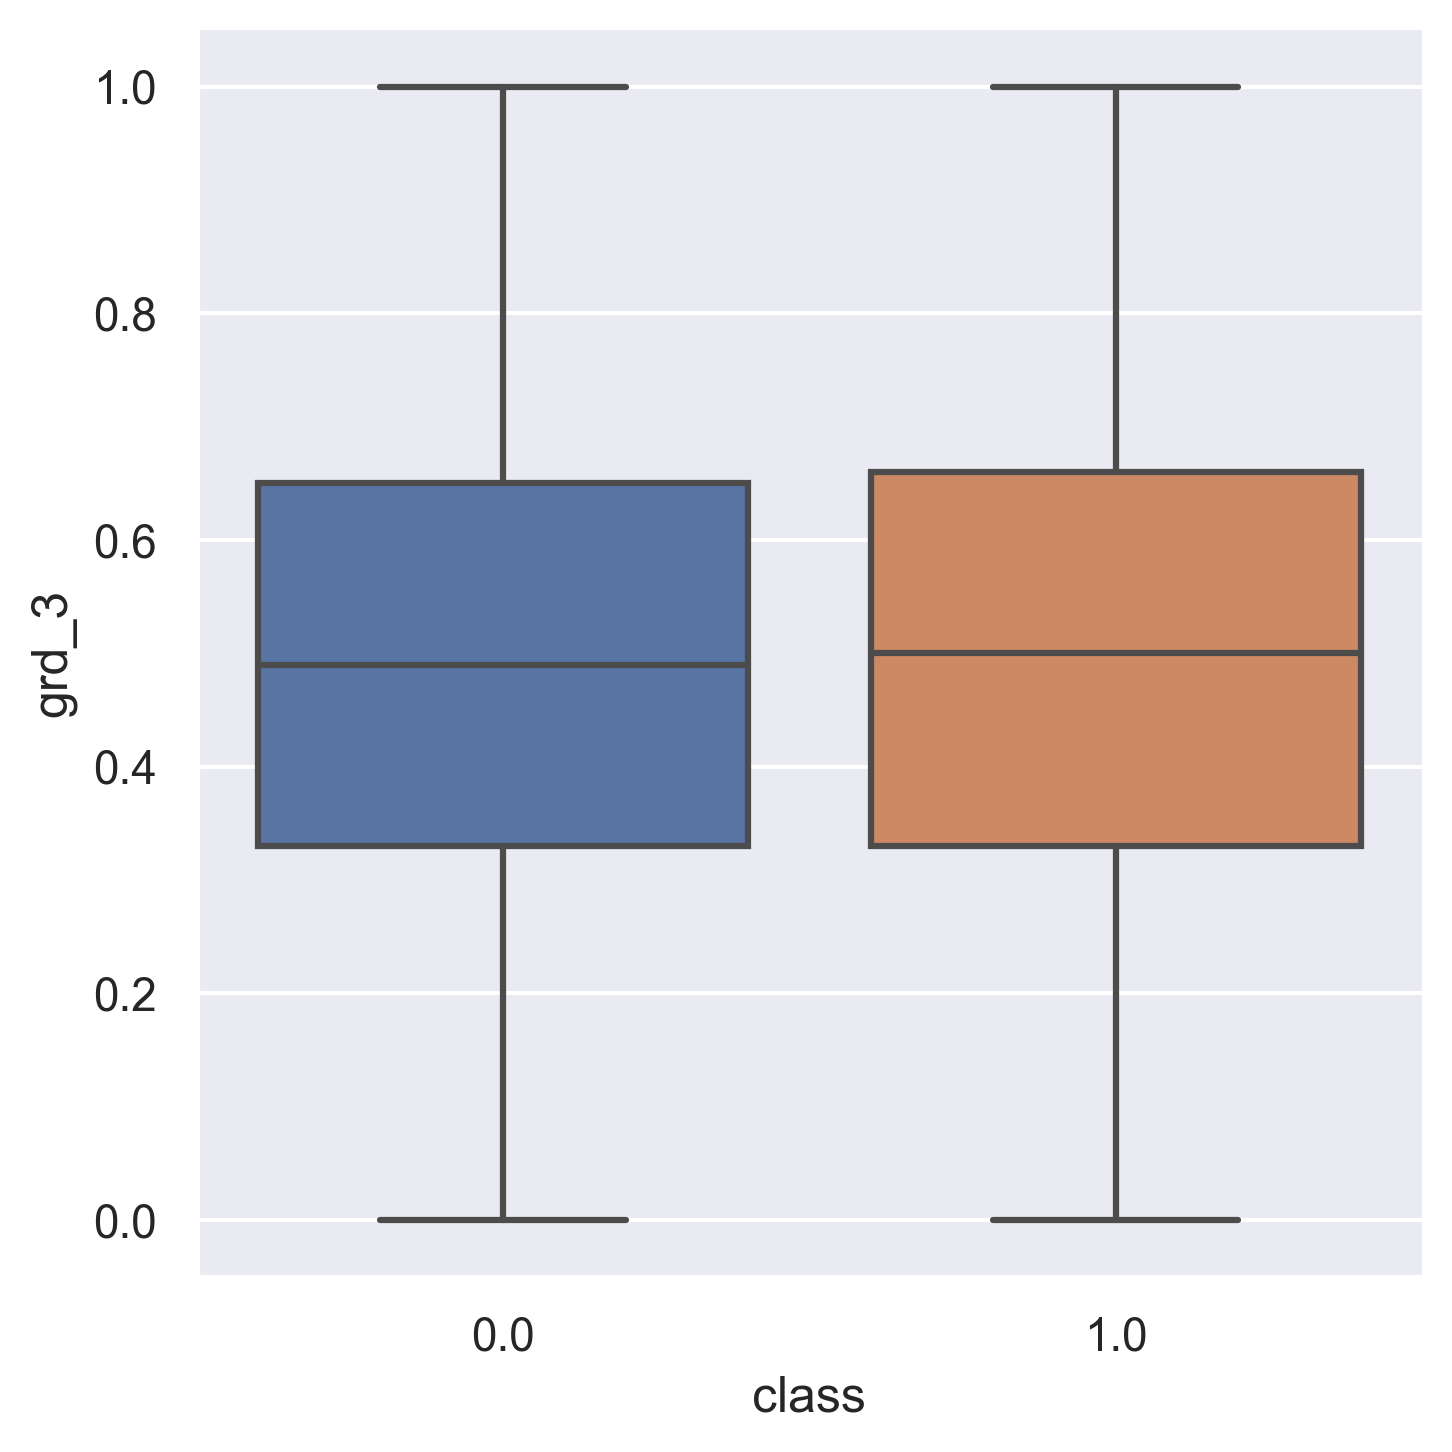

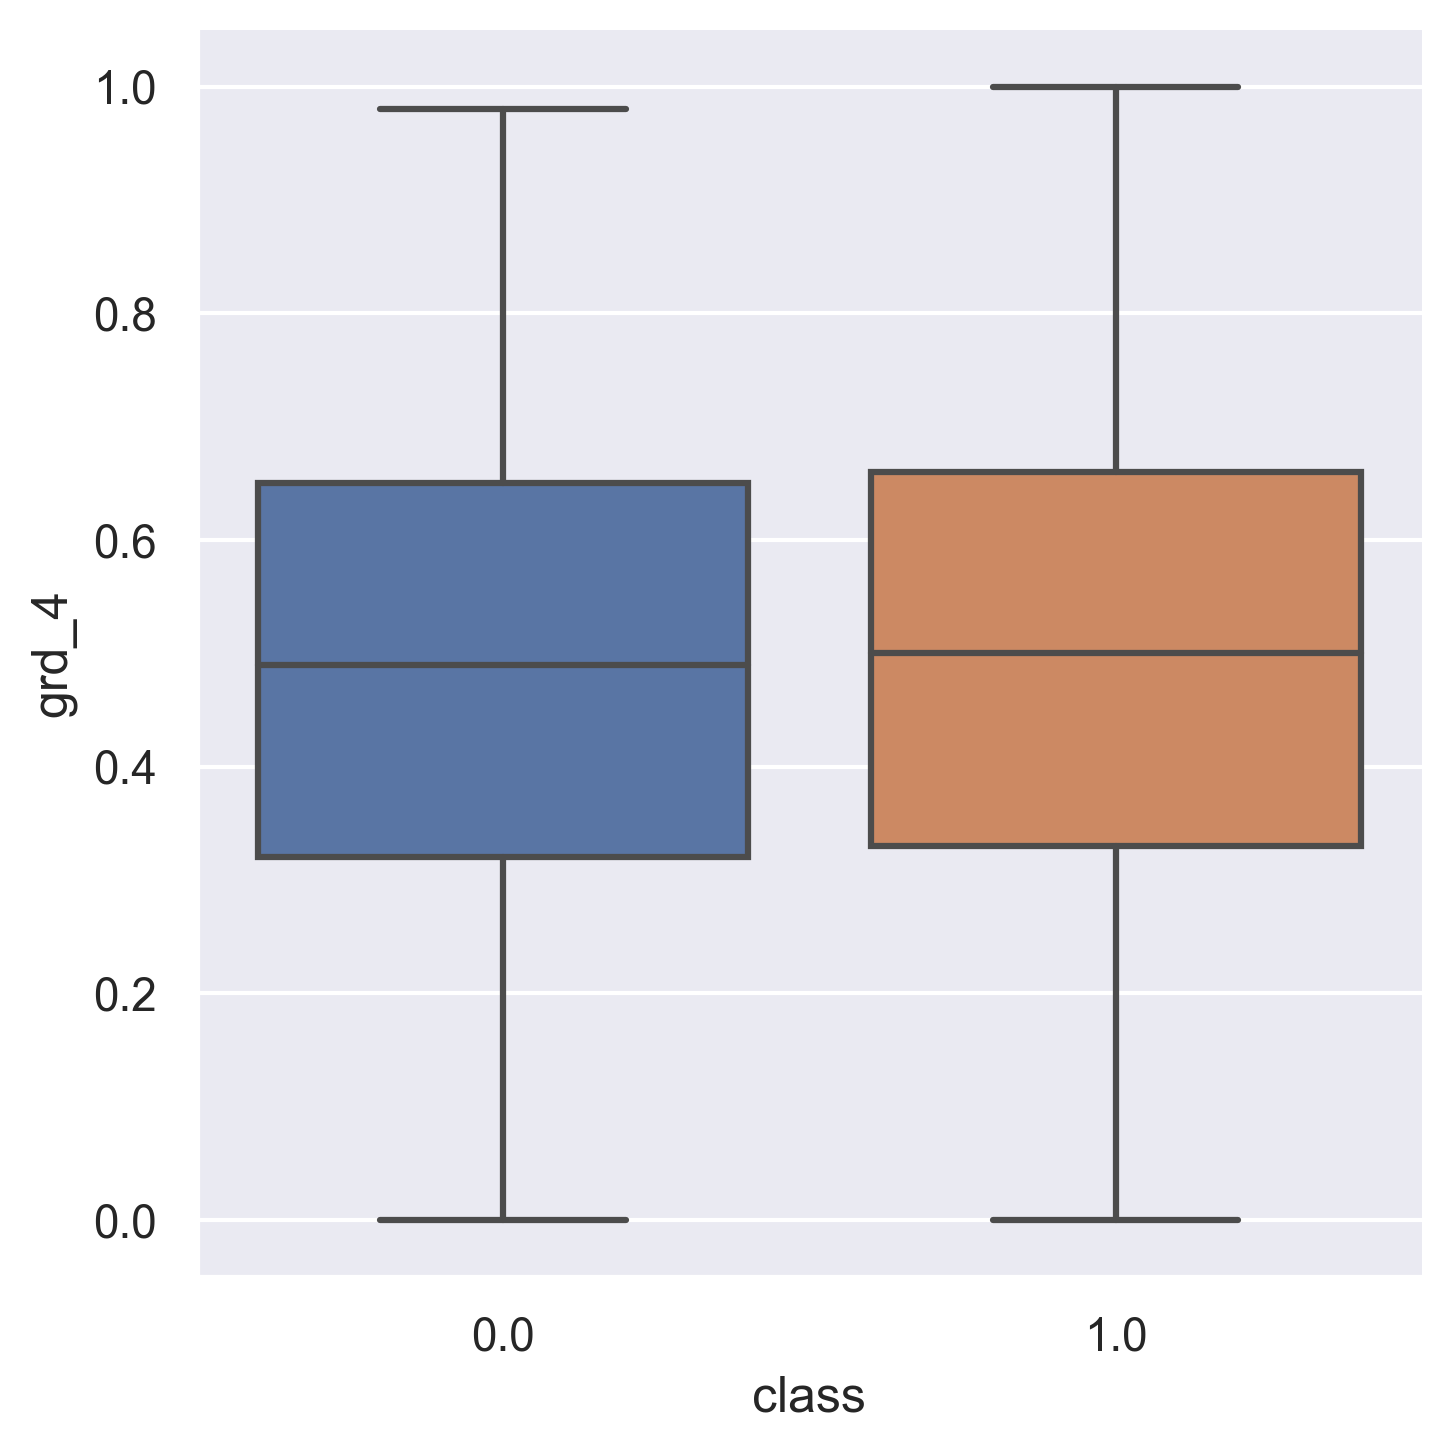

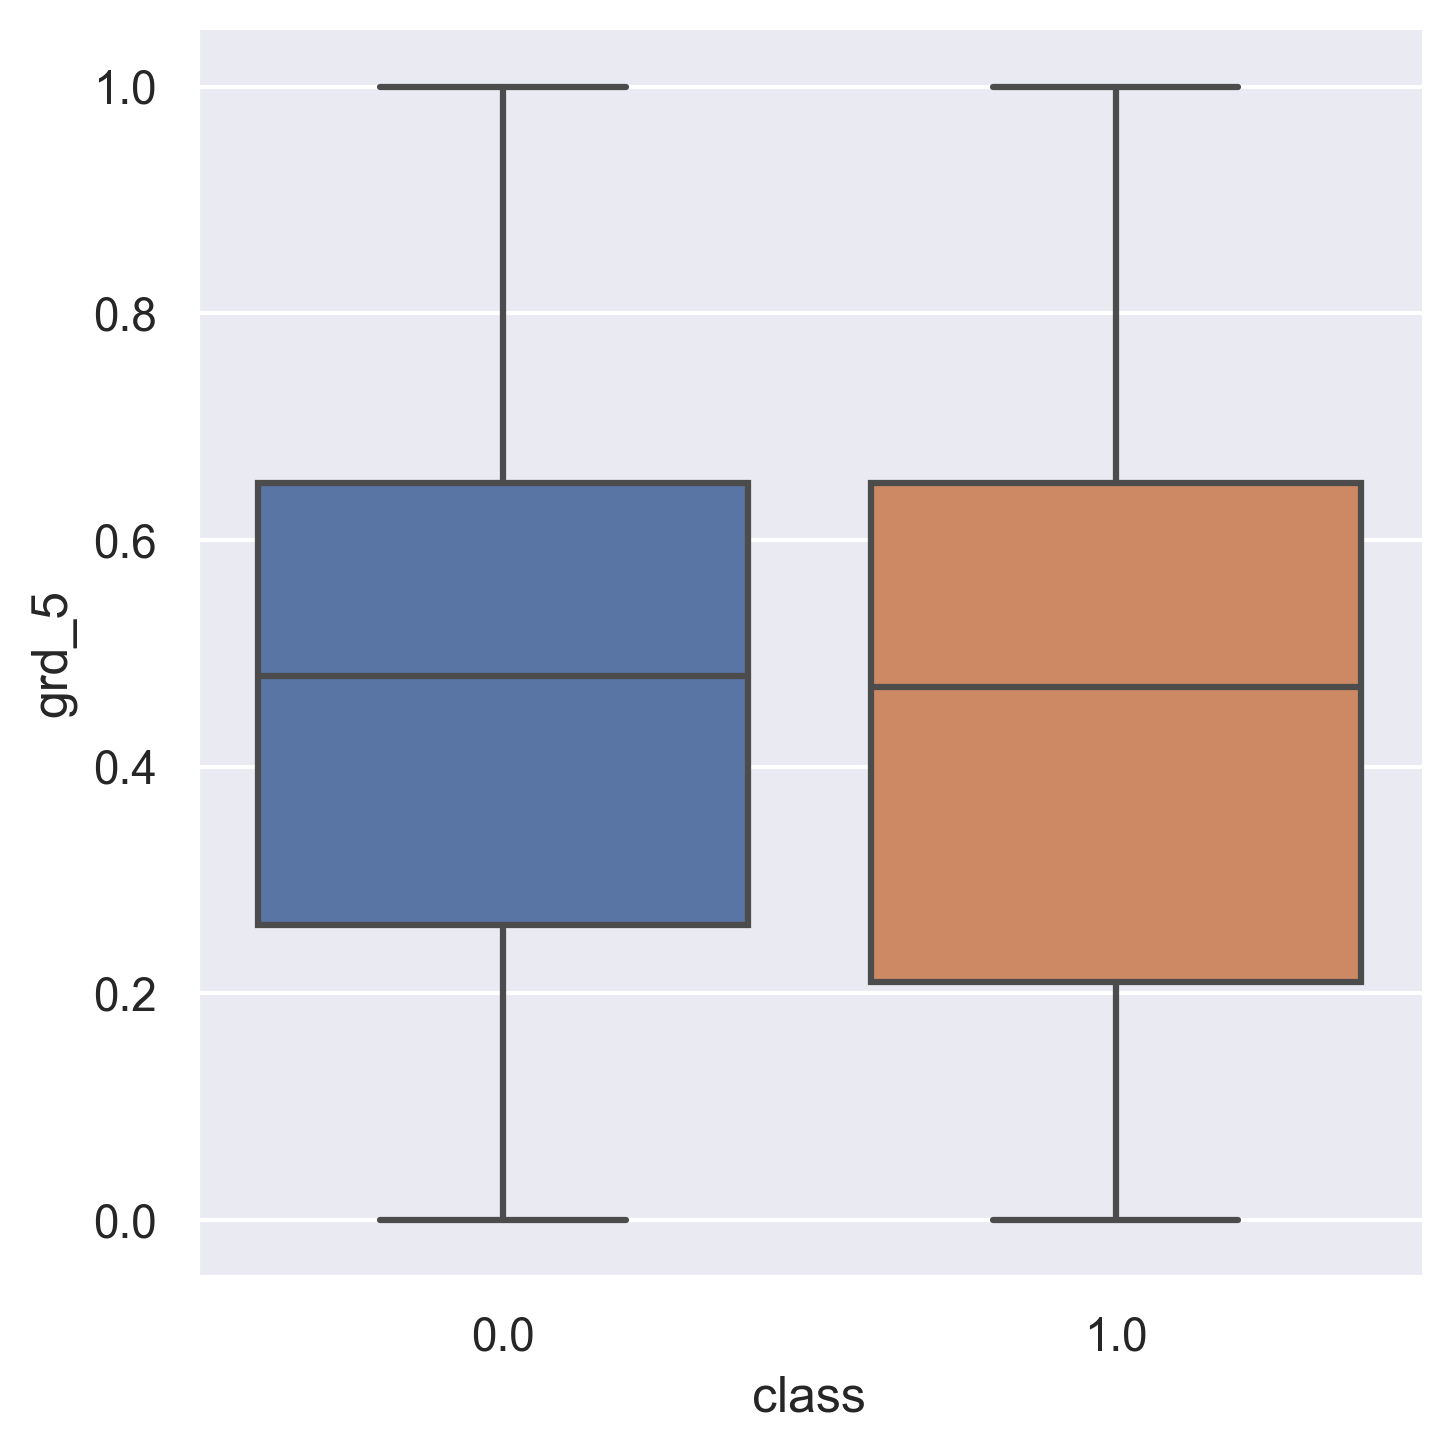

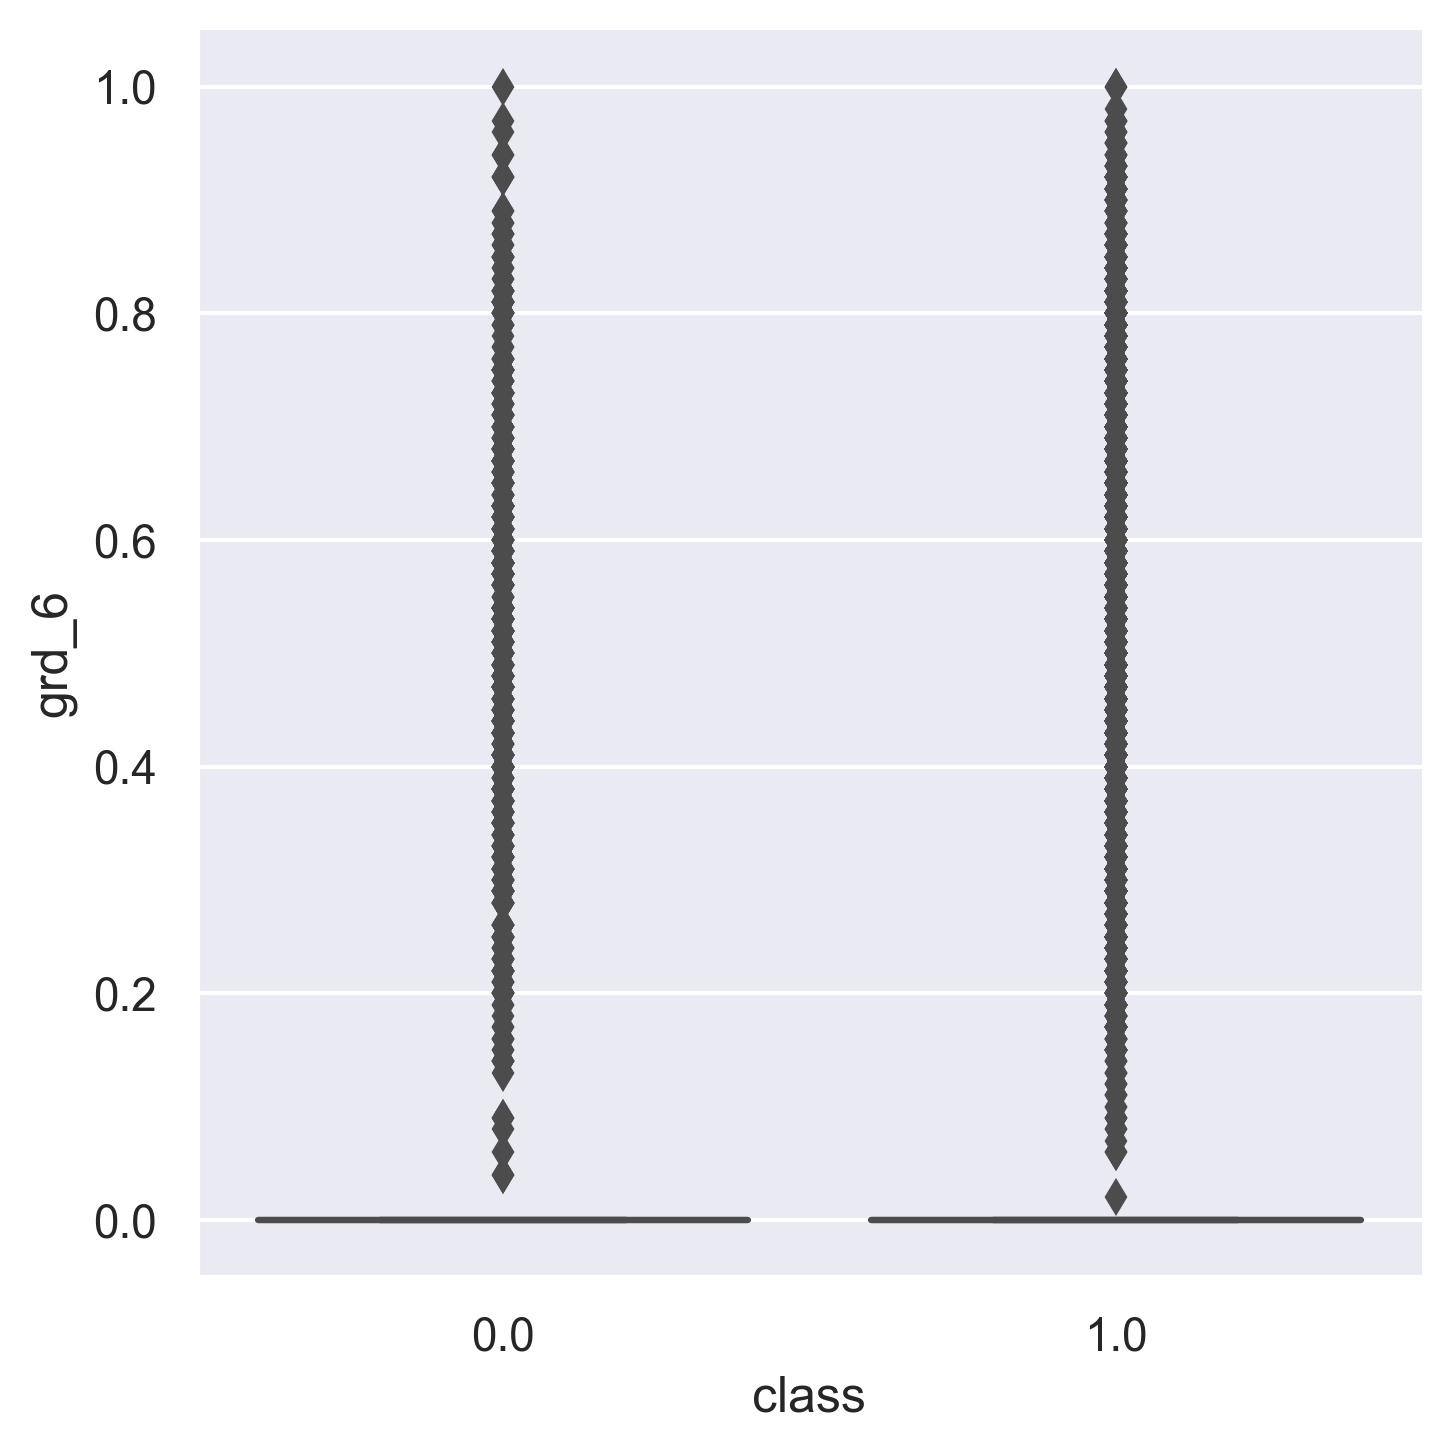

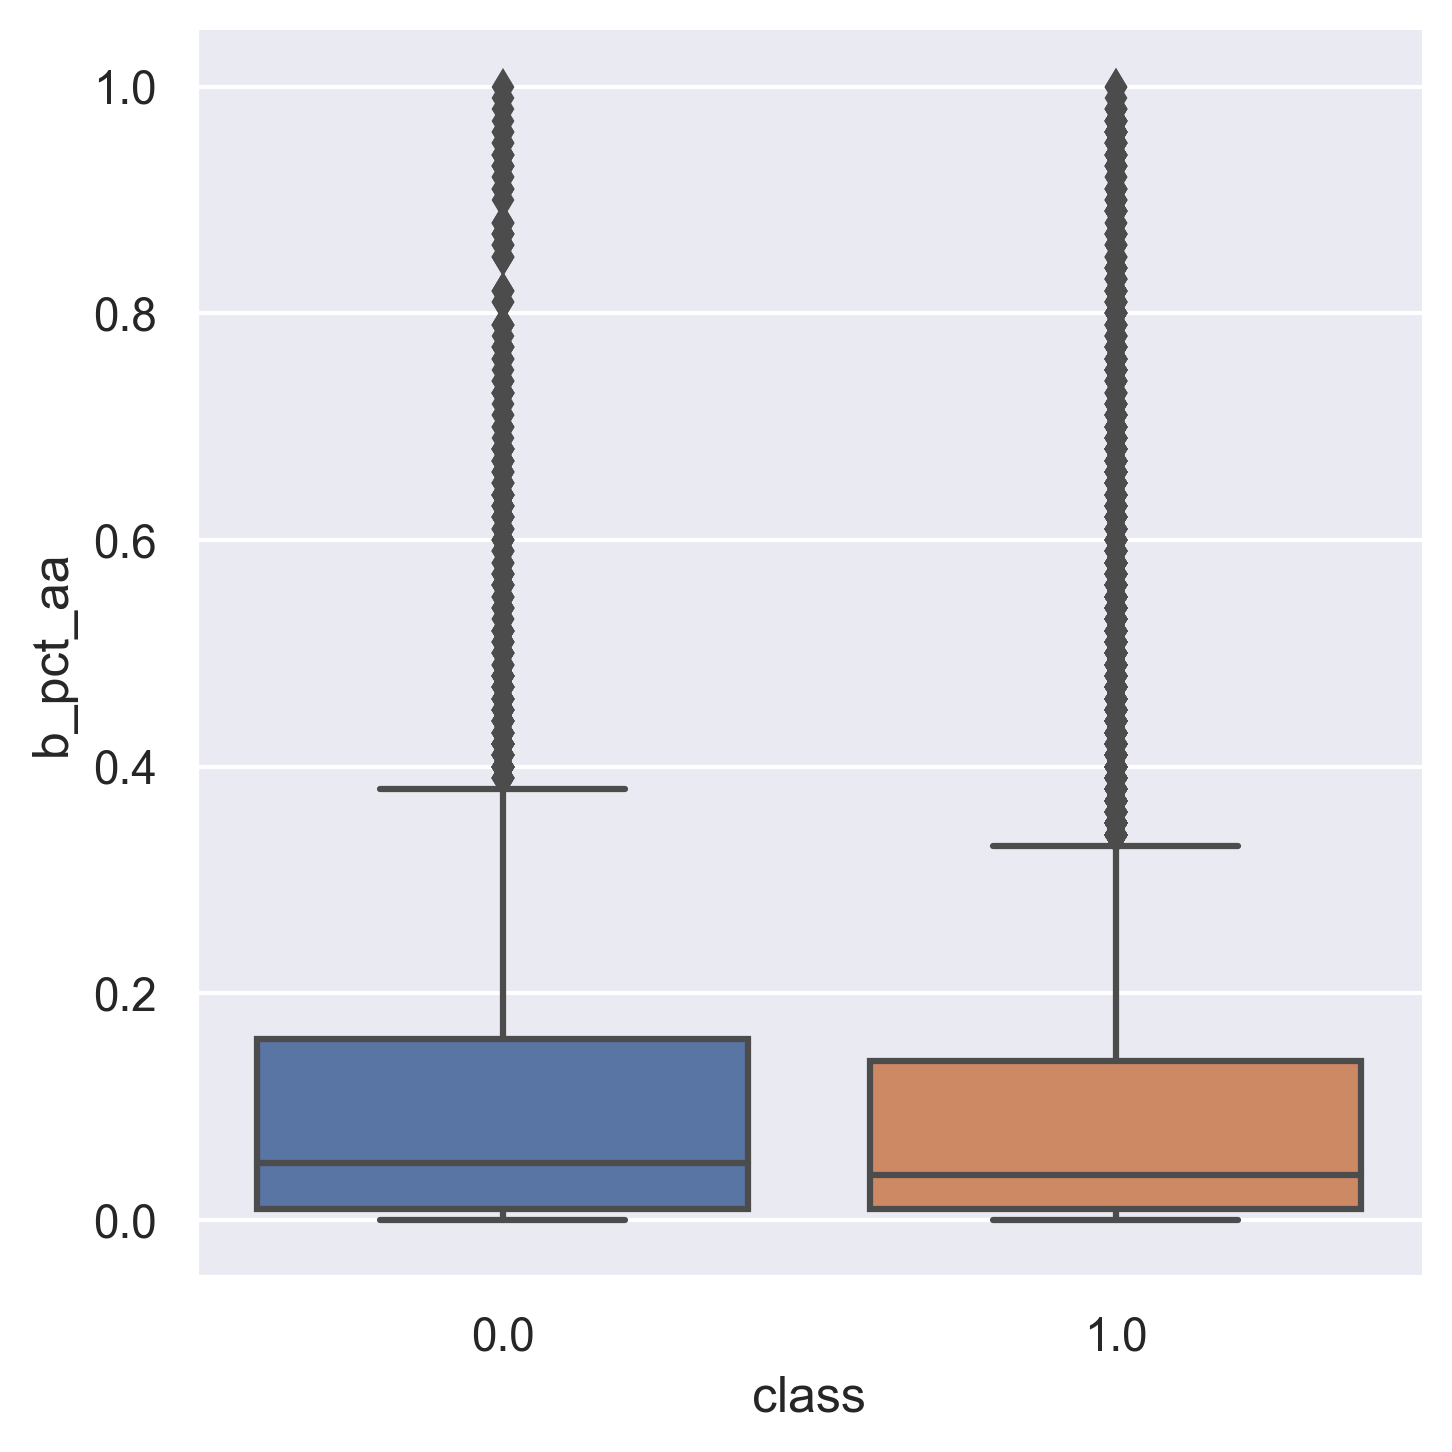

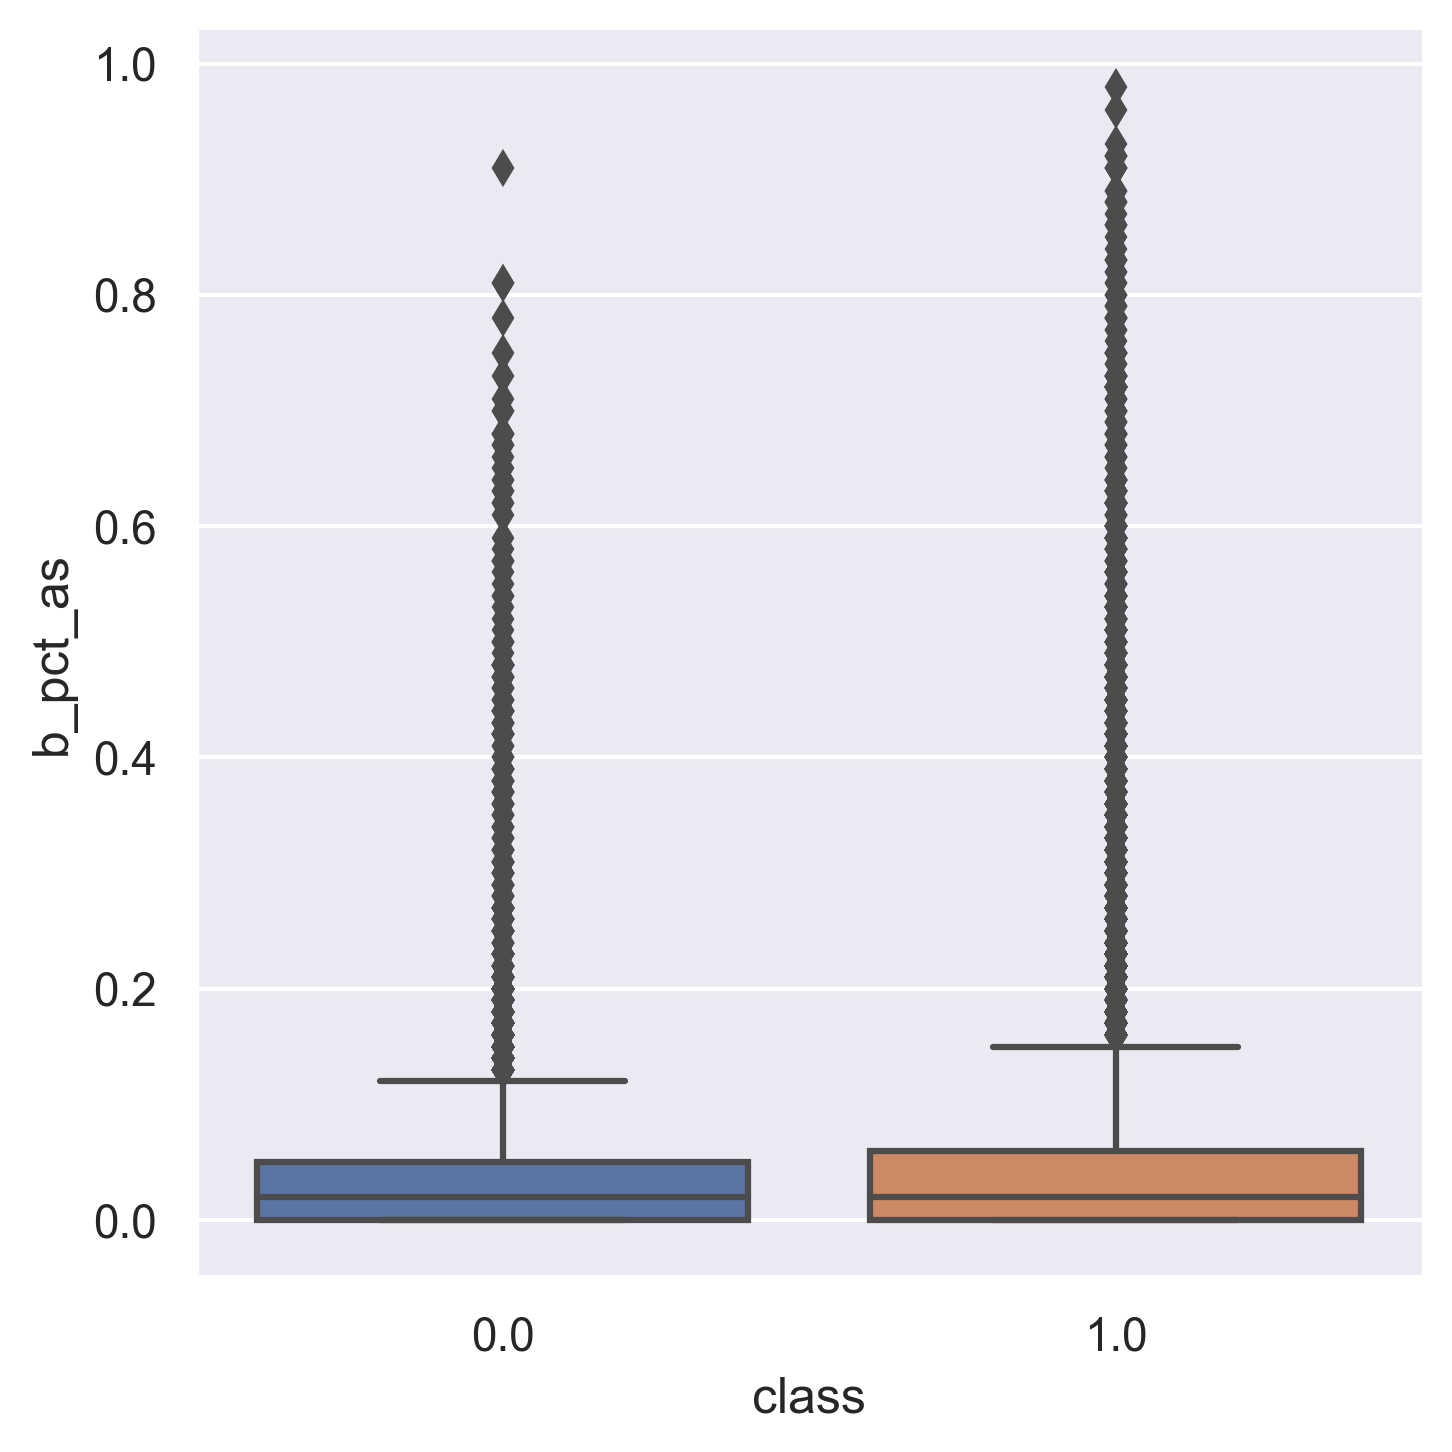

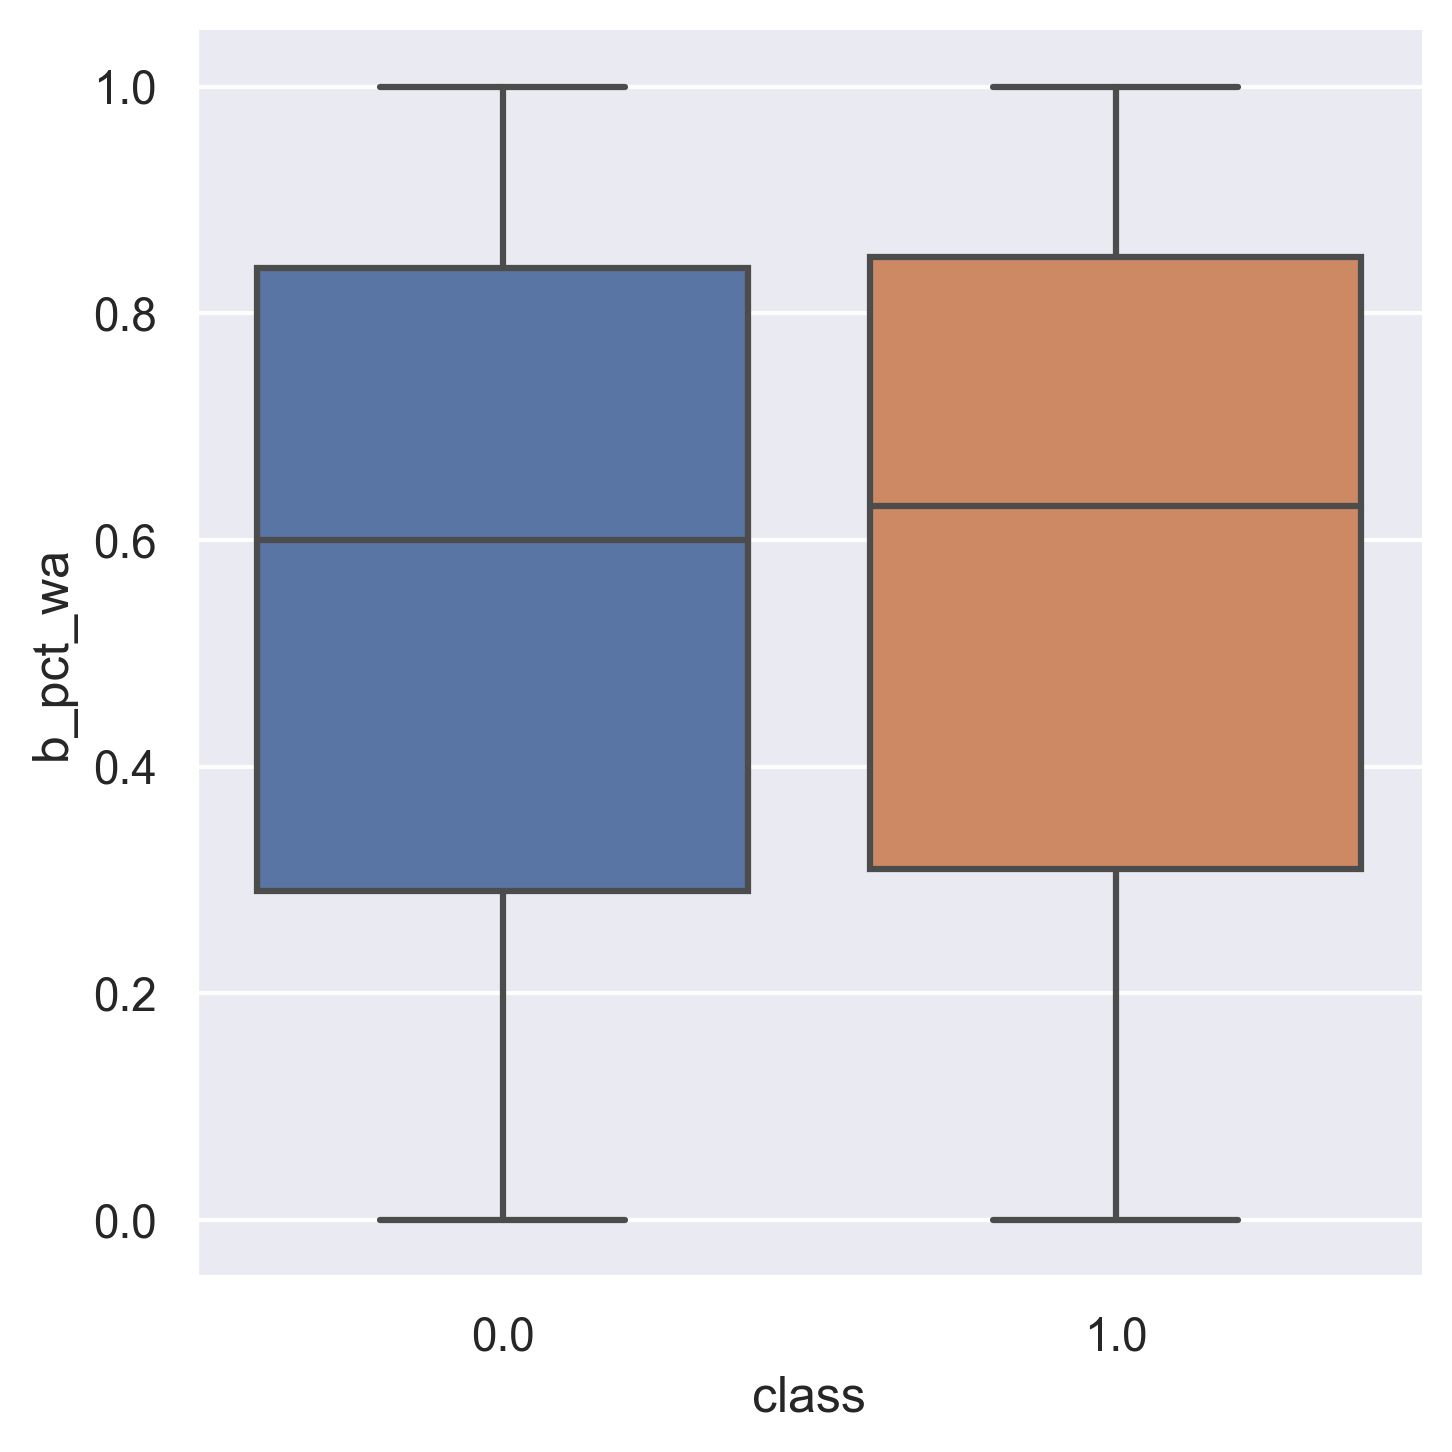

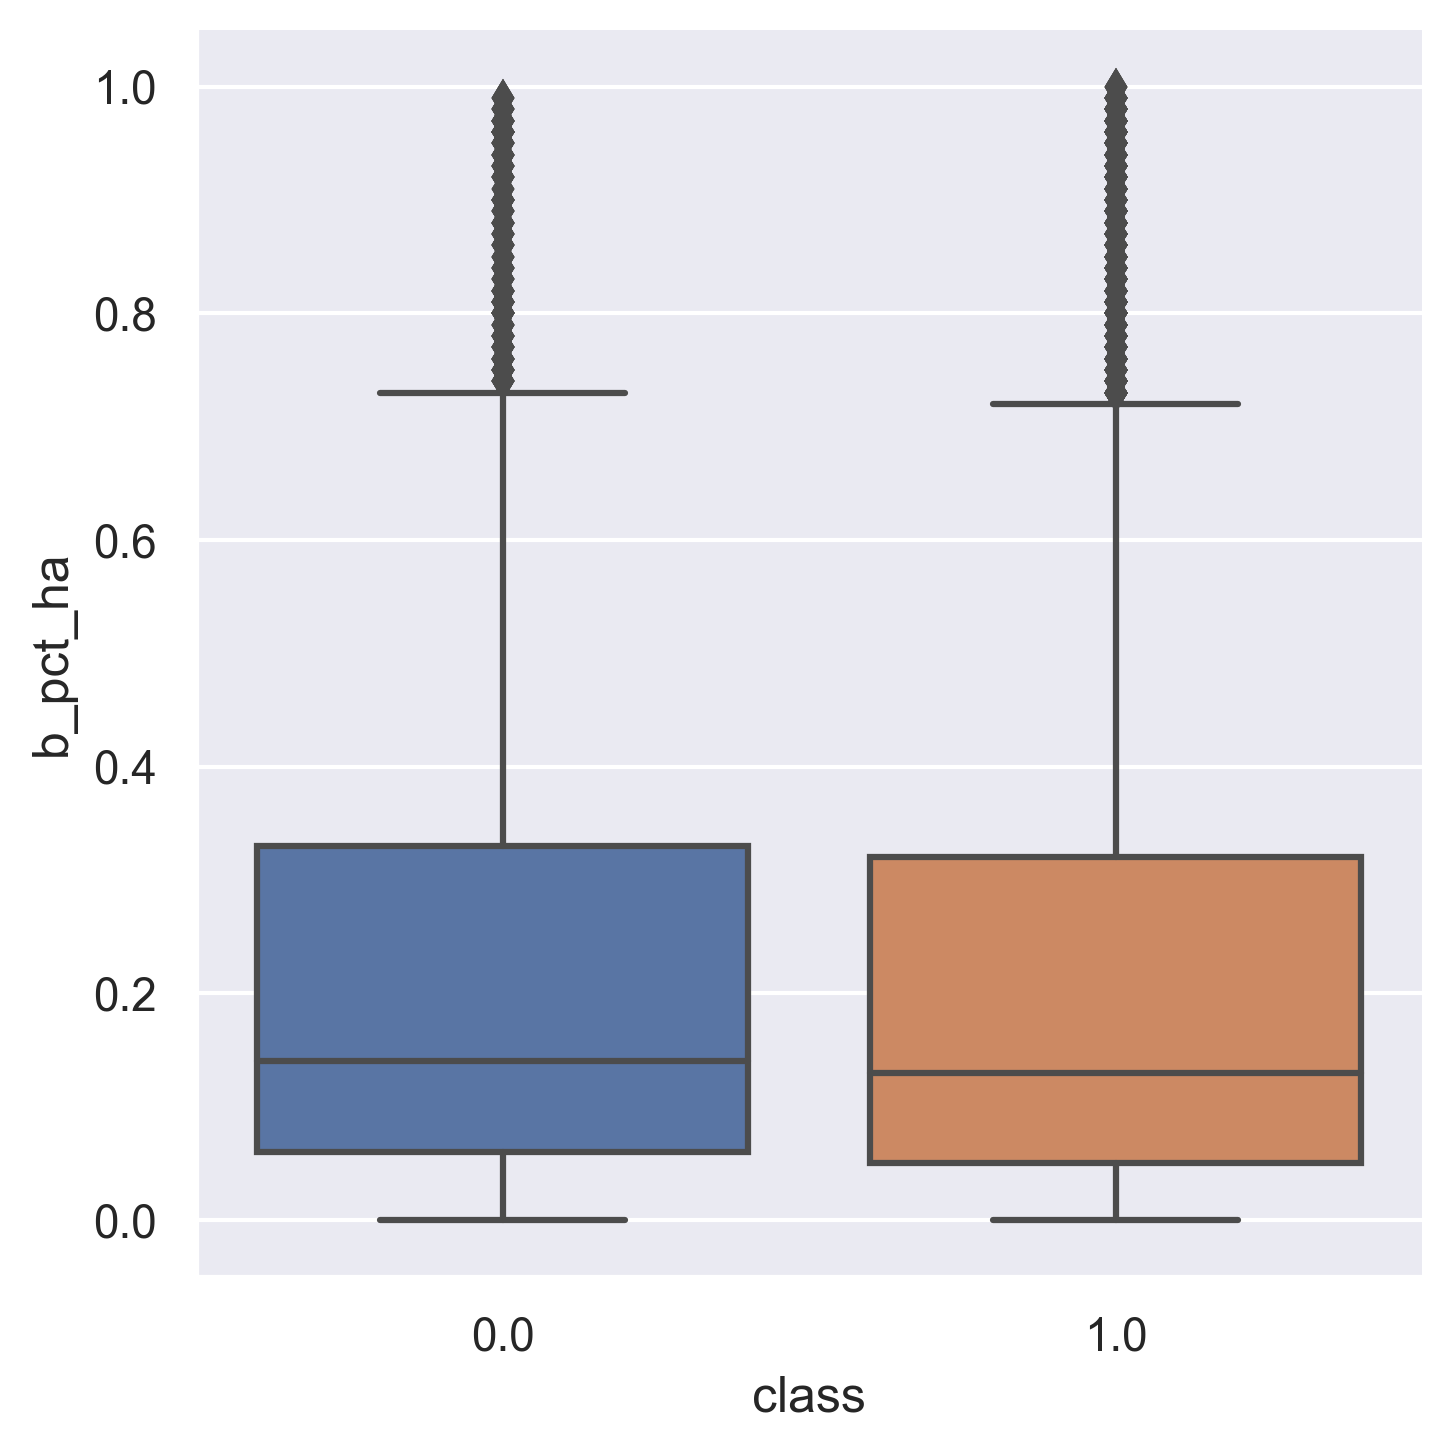

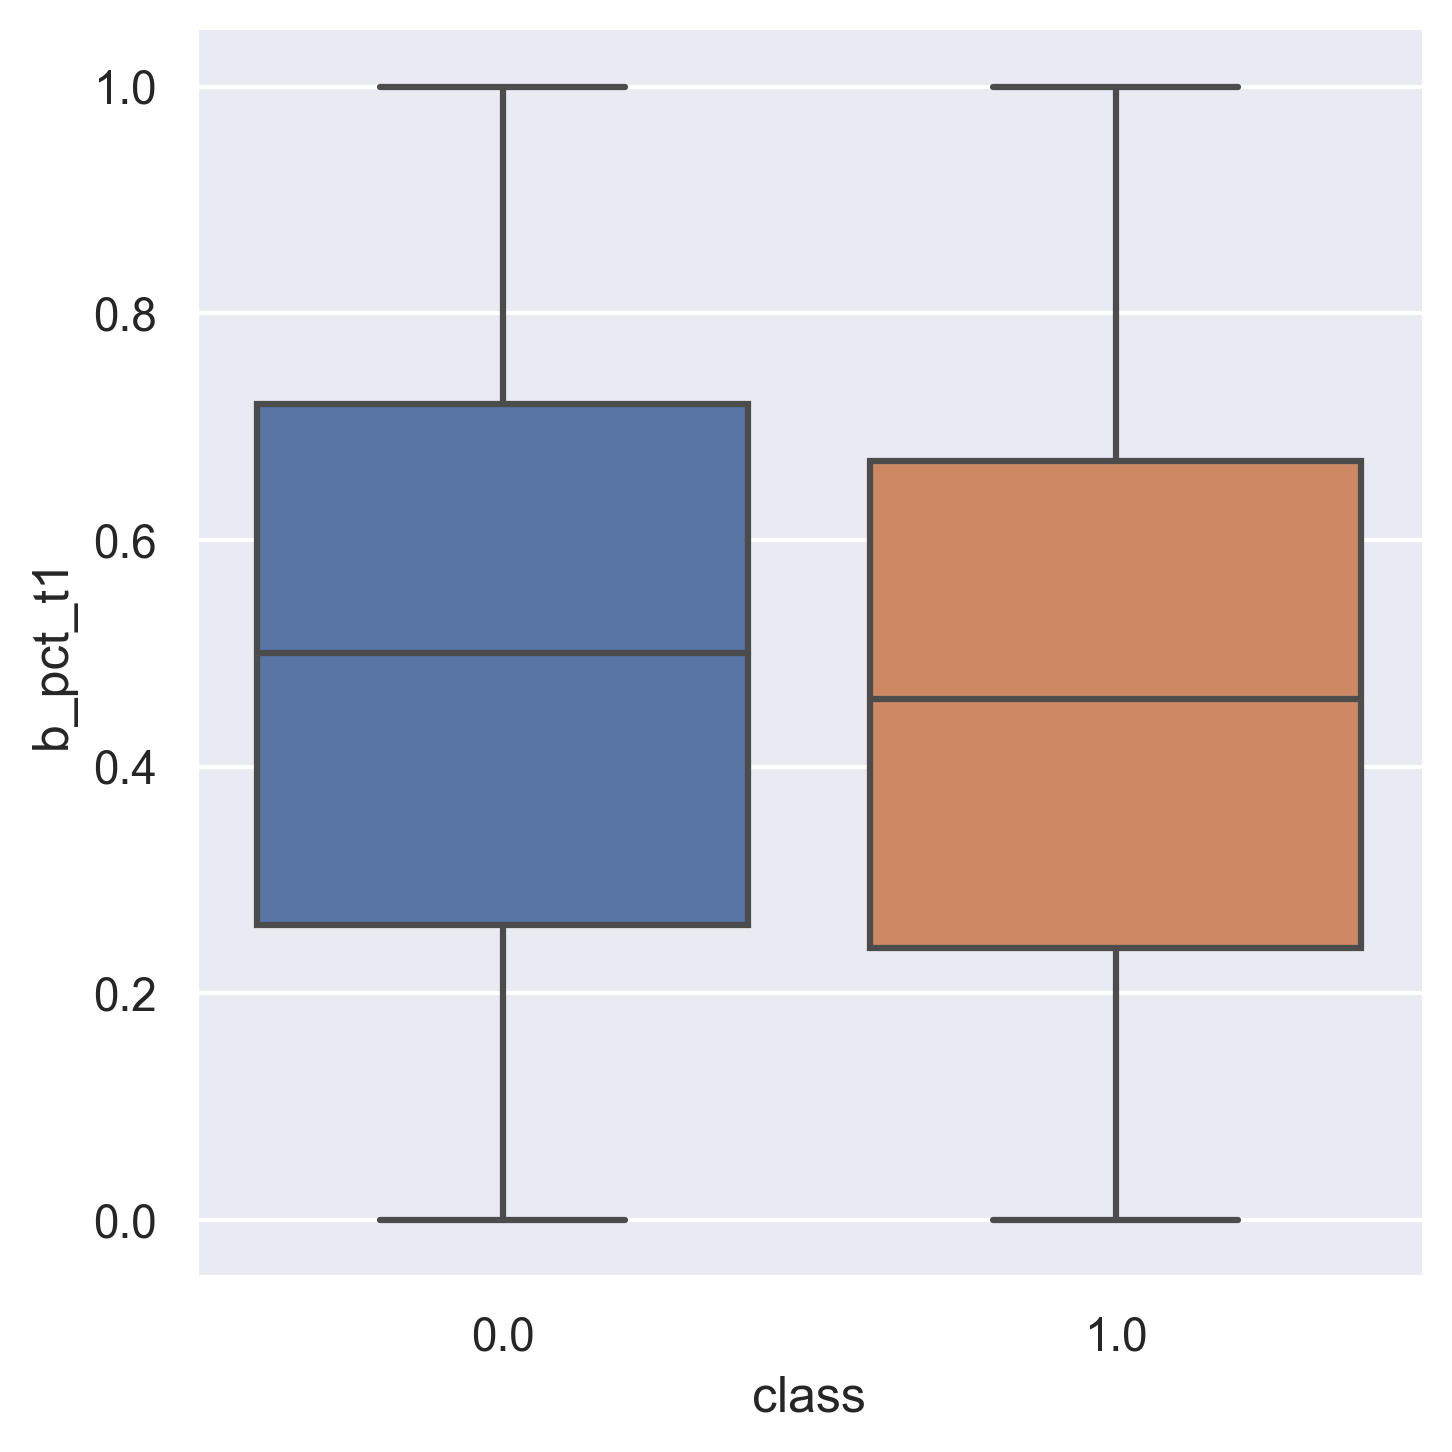

In [629]:
for i, col in enumerate(percent_cols):
	plt.figure(i)
	sns.catplot(x='class', y=col, kind = 'box', data=combined)

<Figure size 3600x2400 with 0 Axes>

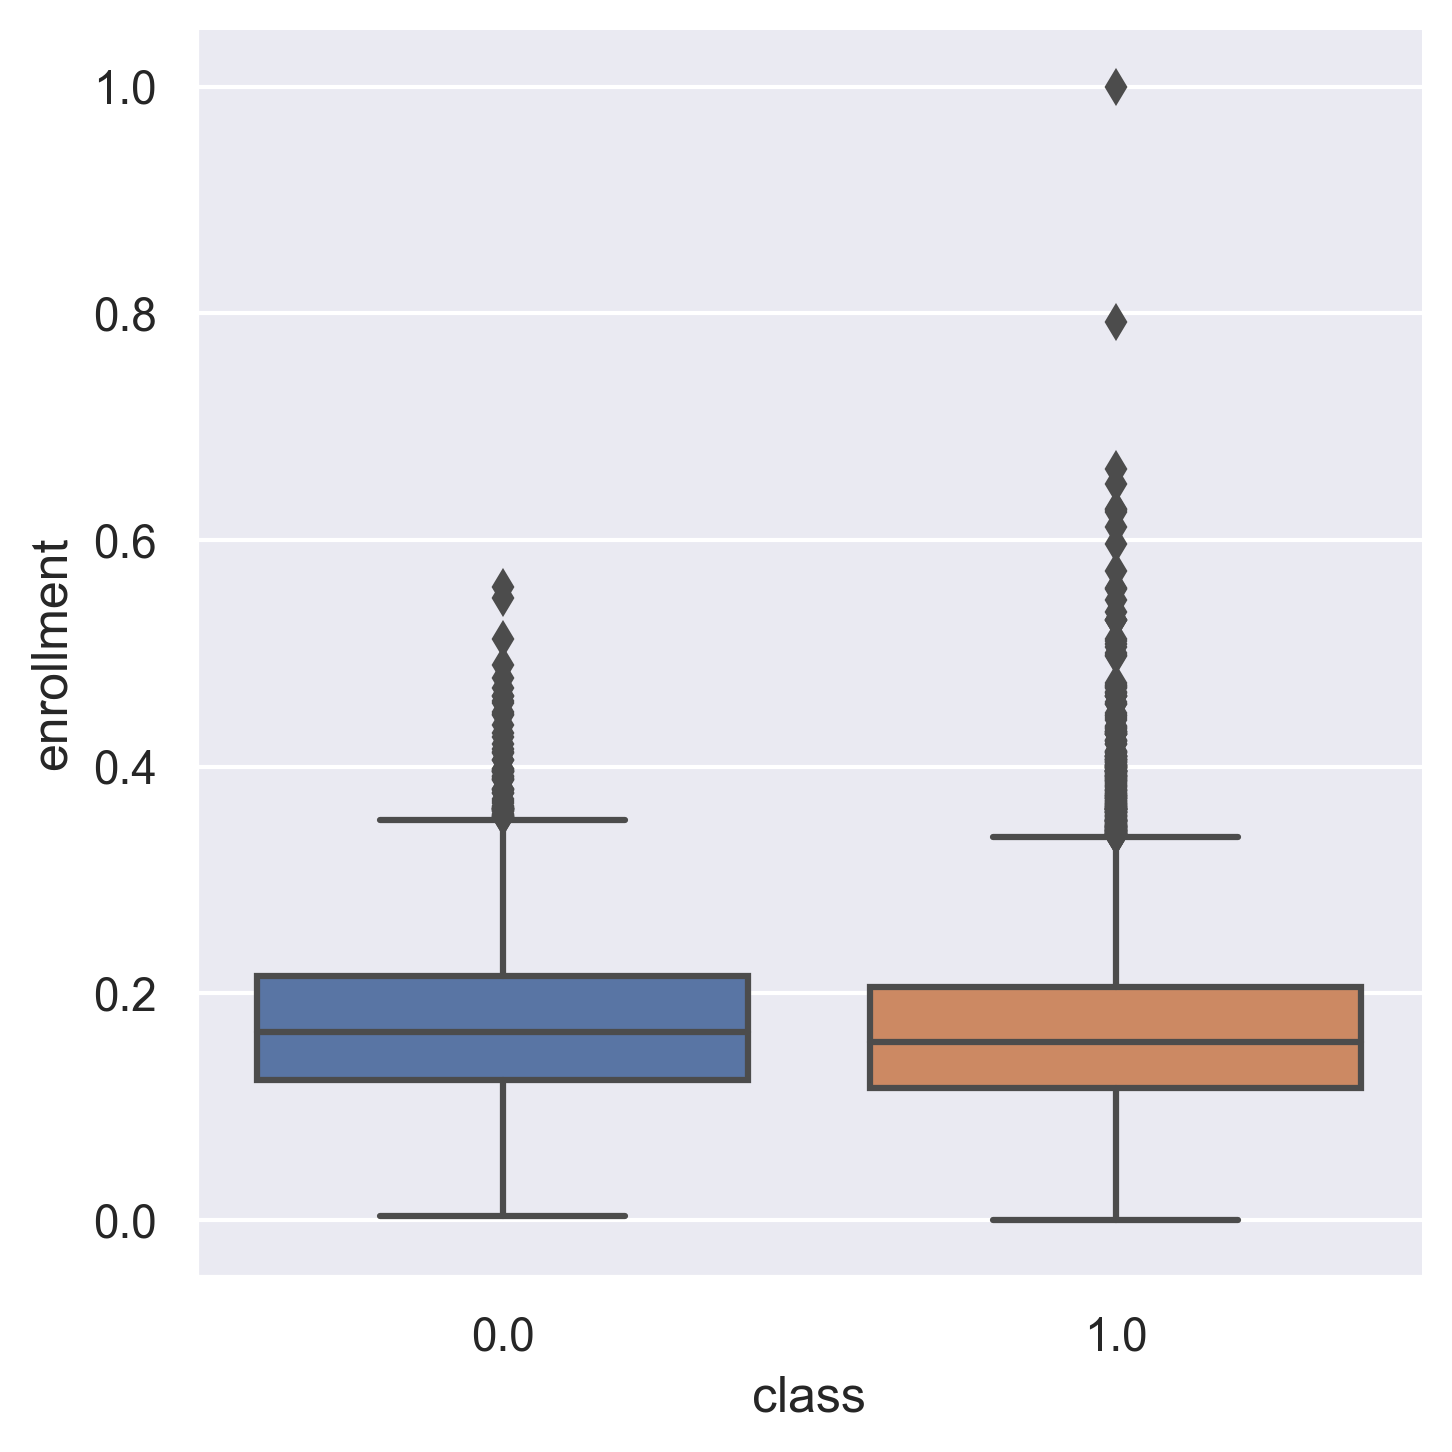

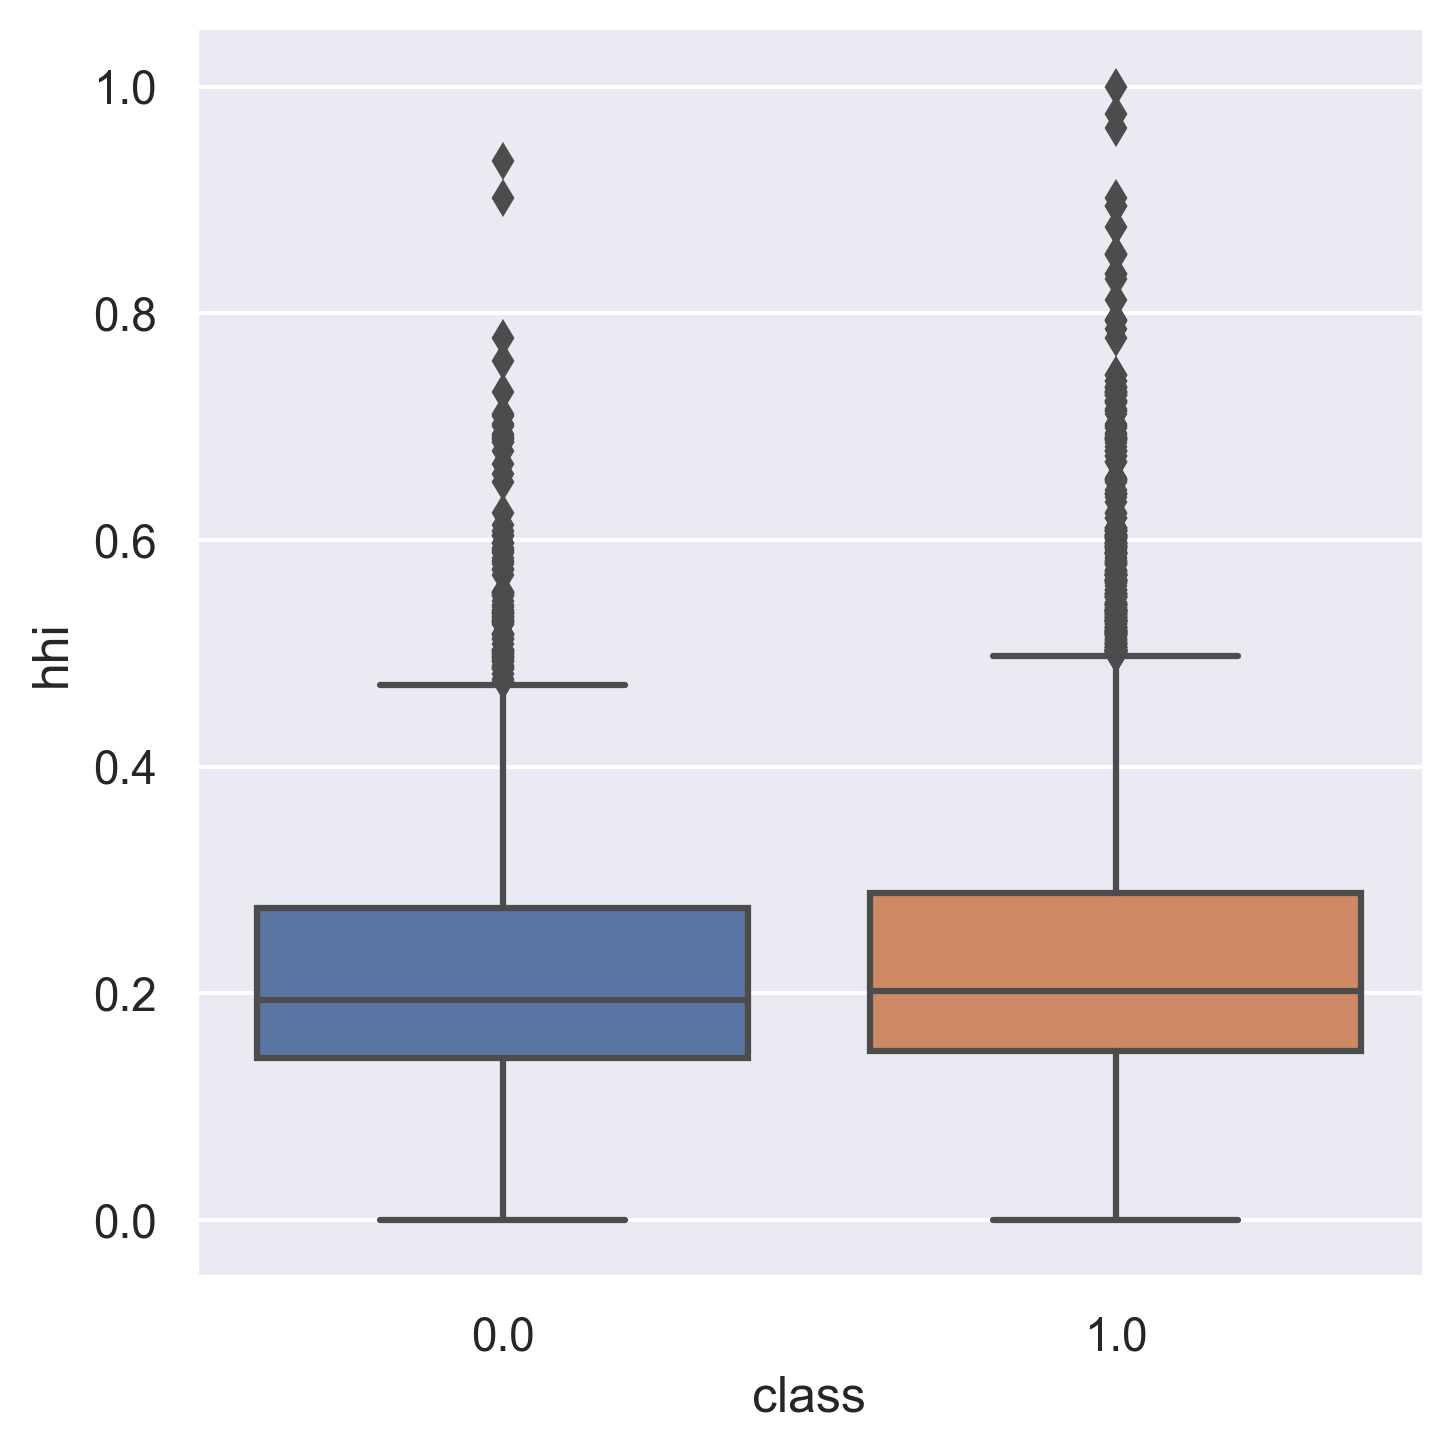

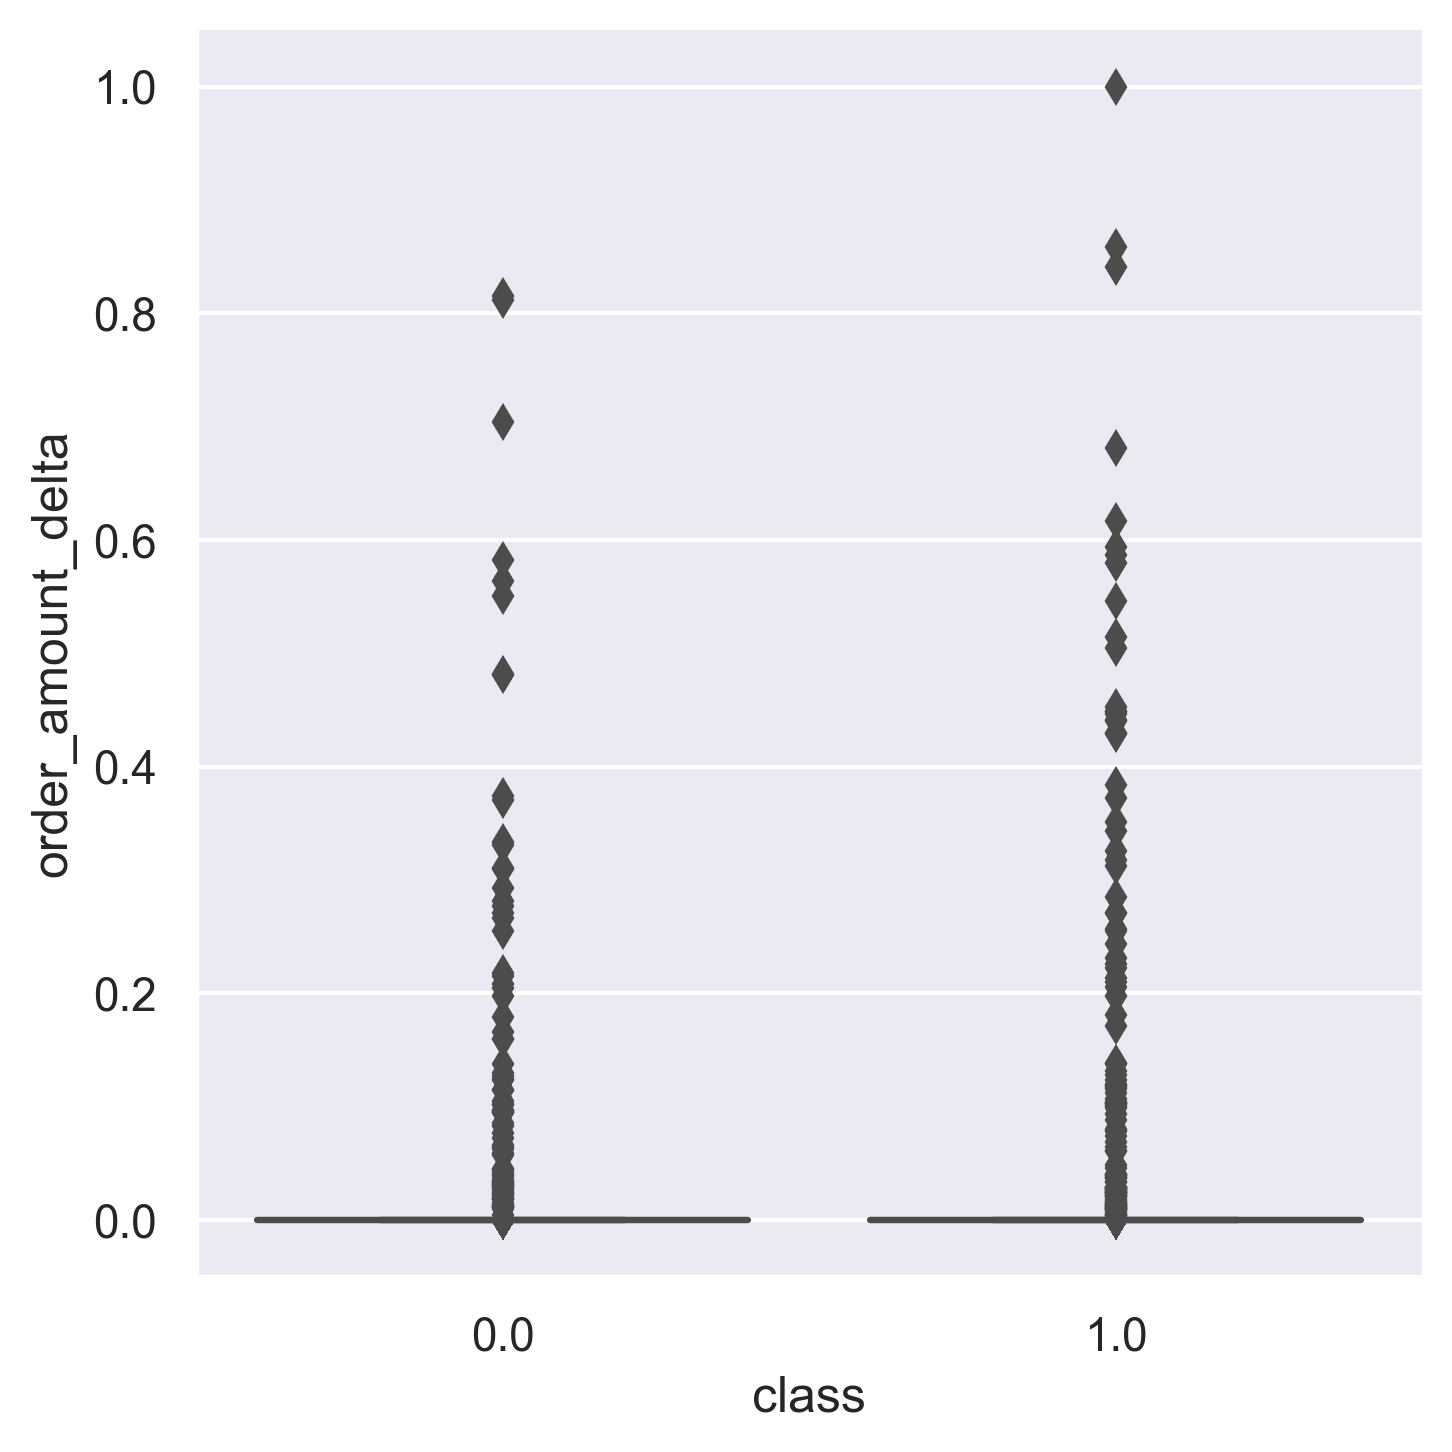

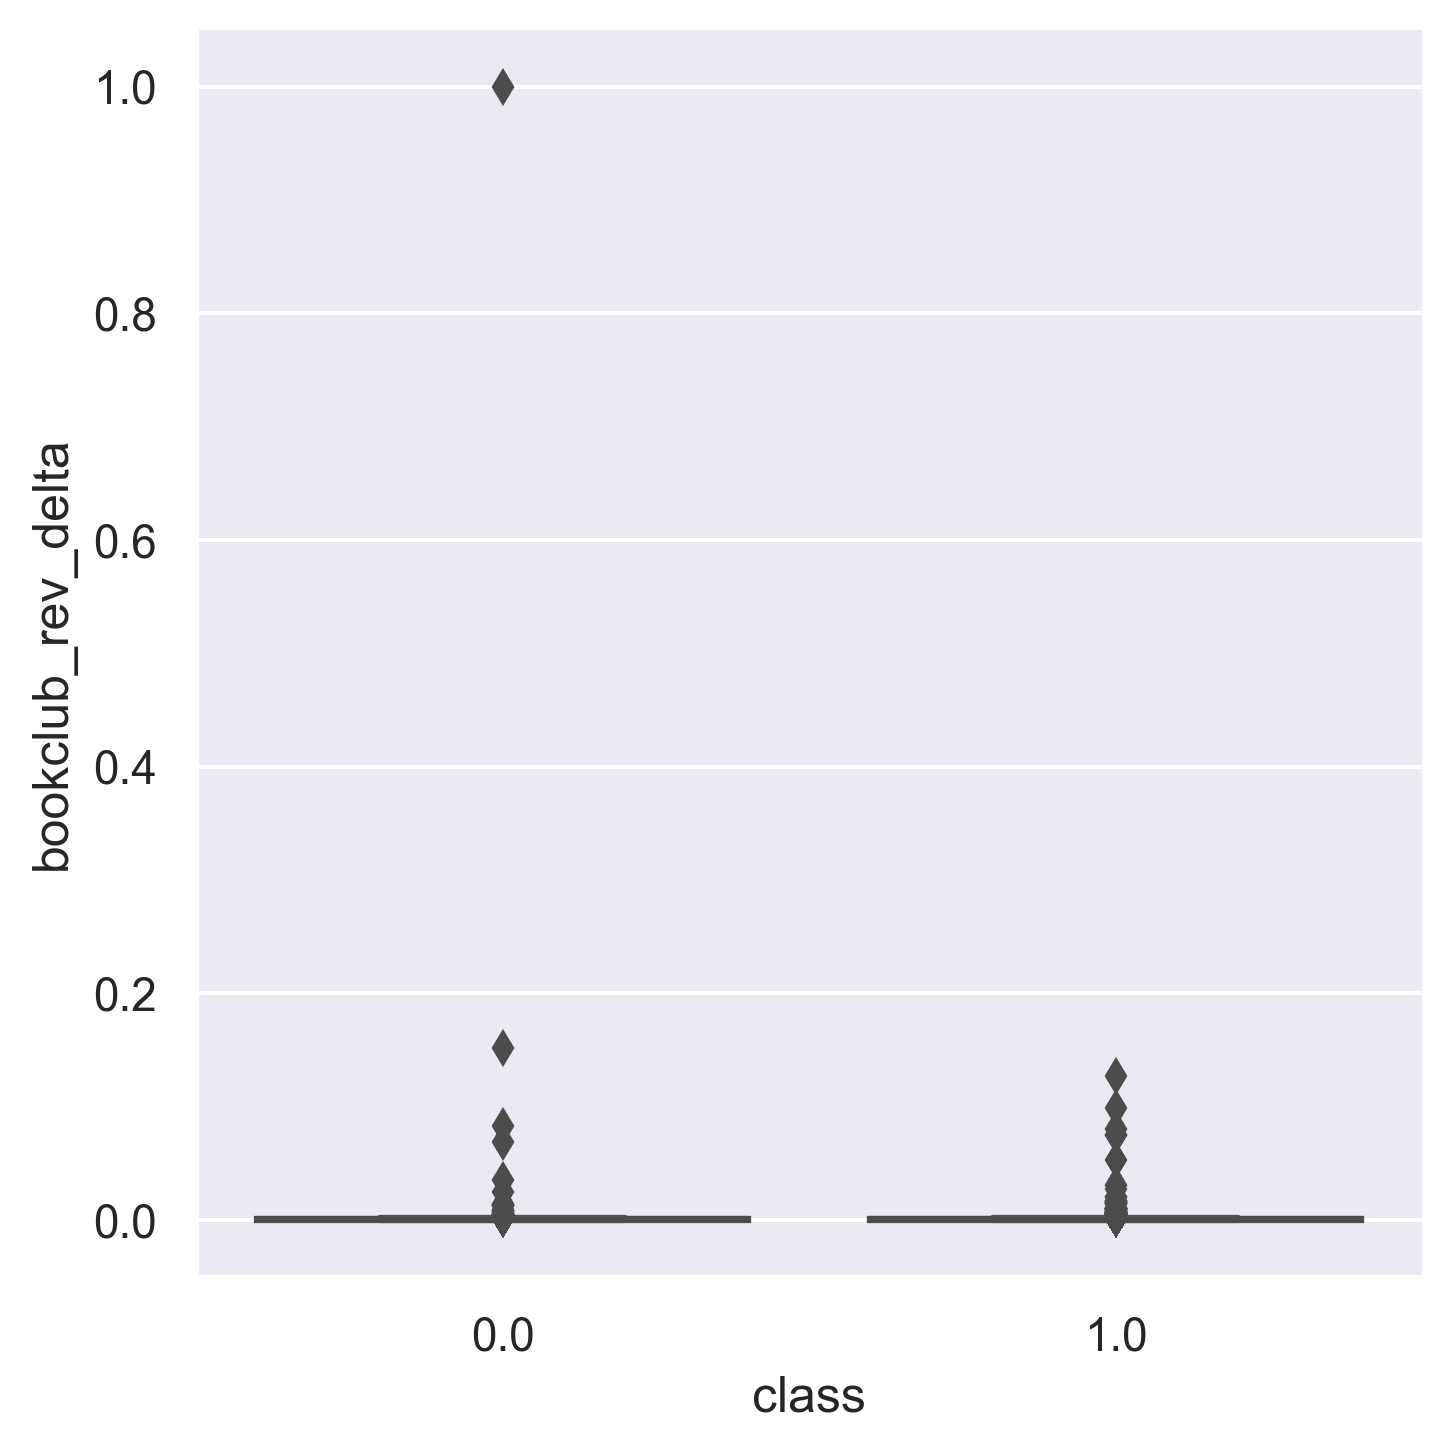

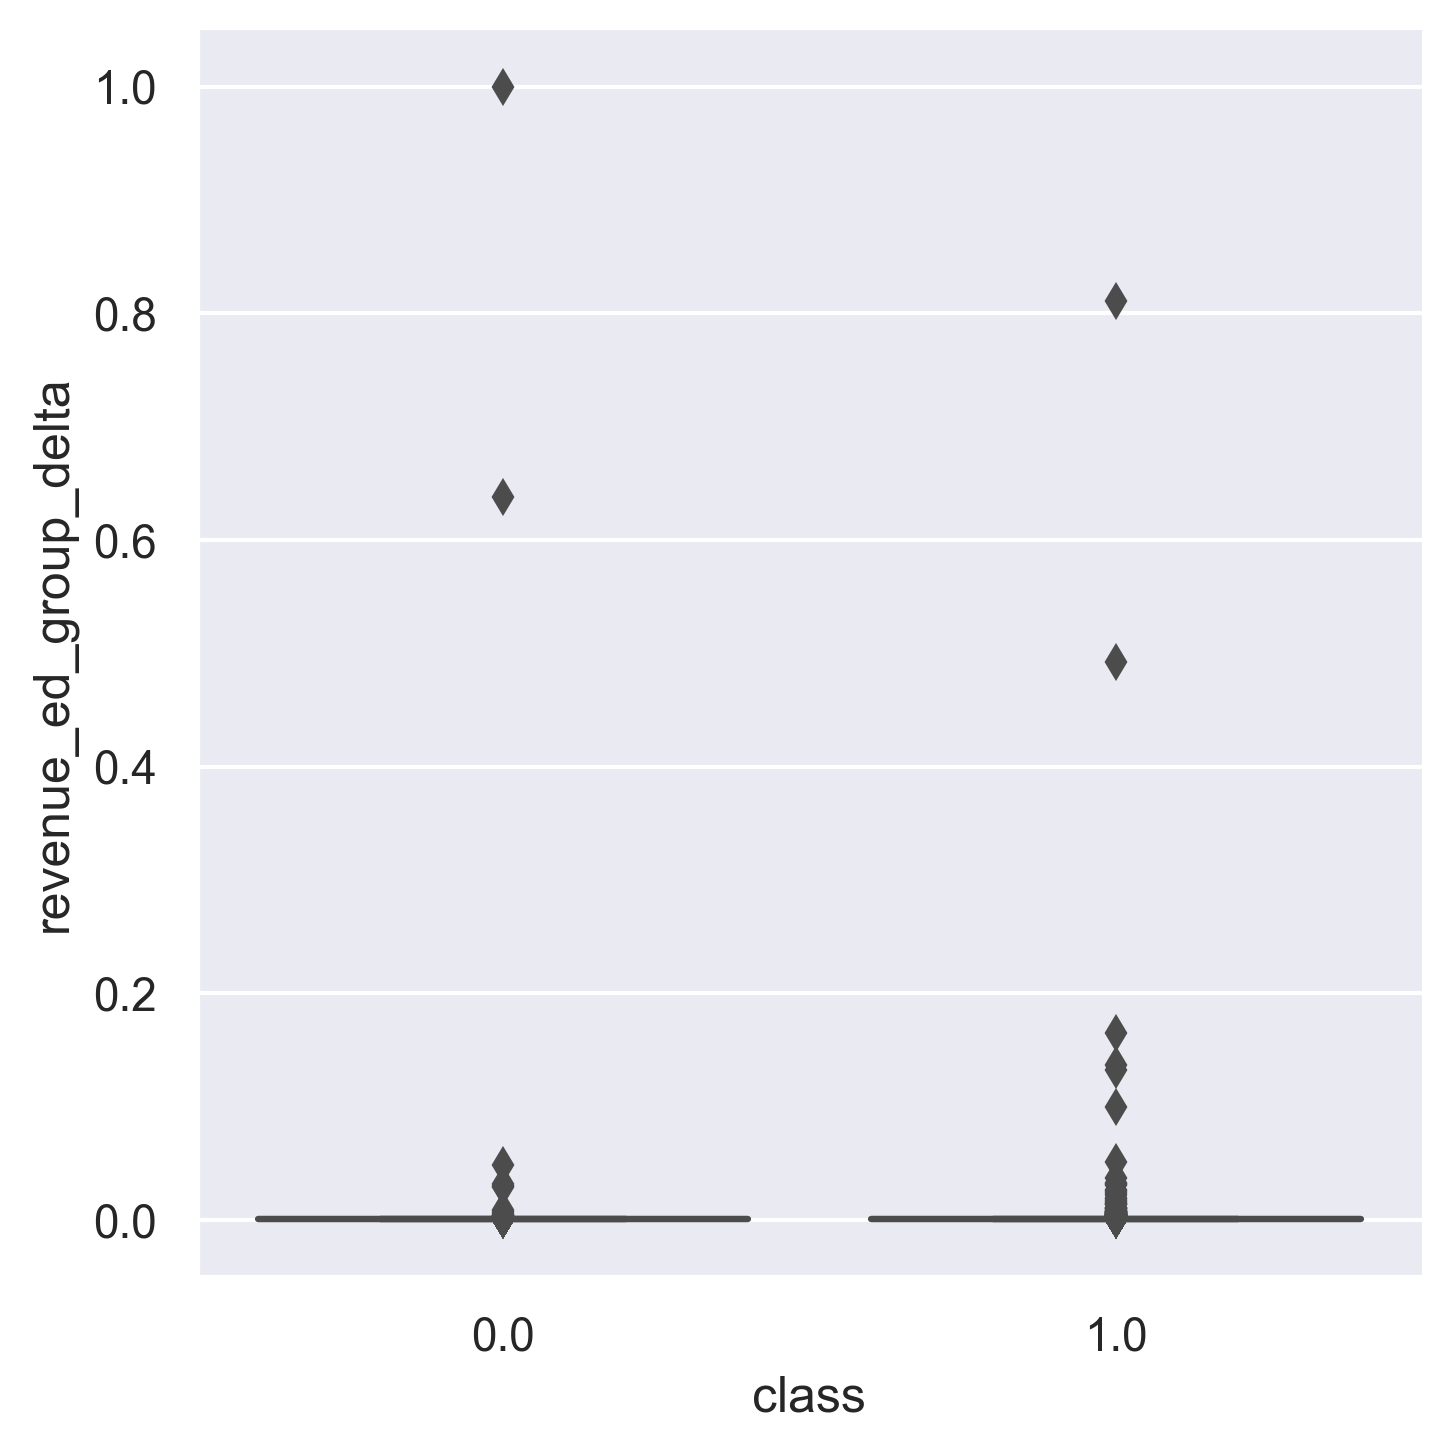

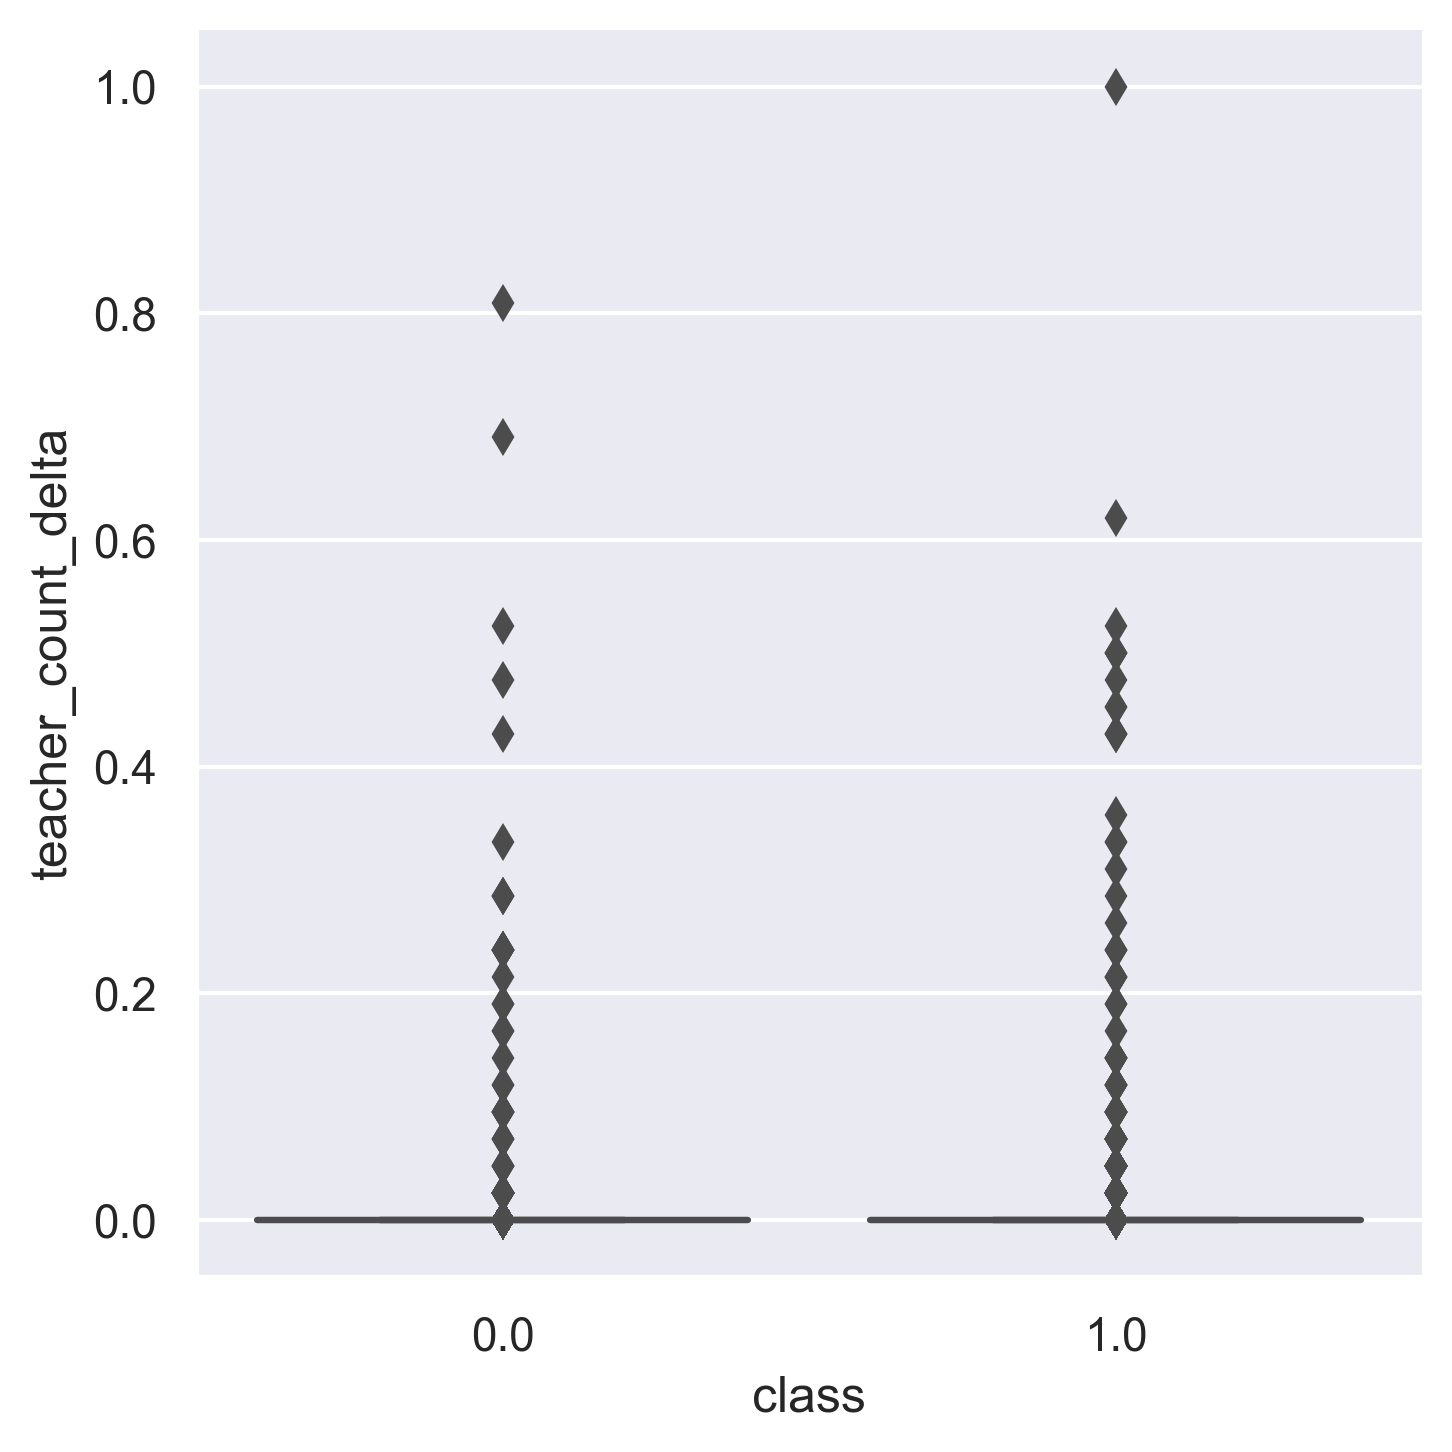

In [630]:
for i, col in enumerate(scale_cols):
	plt.figure(i)
	sns.catplot(x='class', y=col, kind = 'box', data=combined)

## Correlational Analysis of All Features

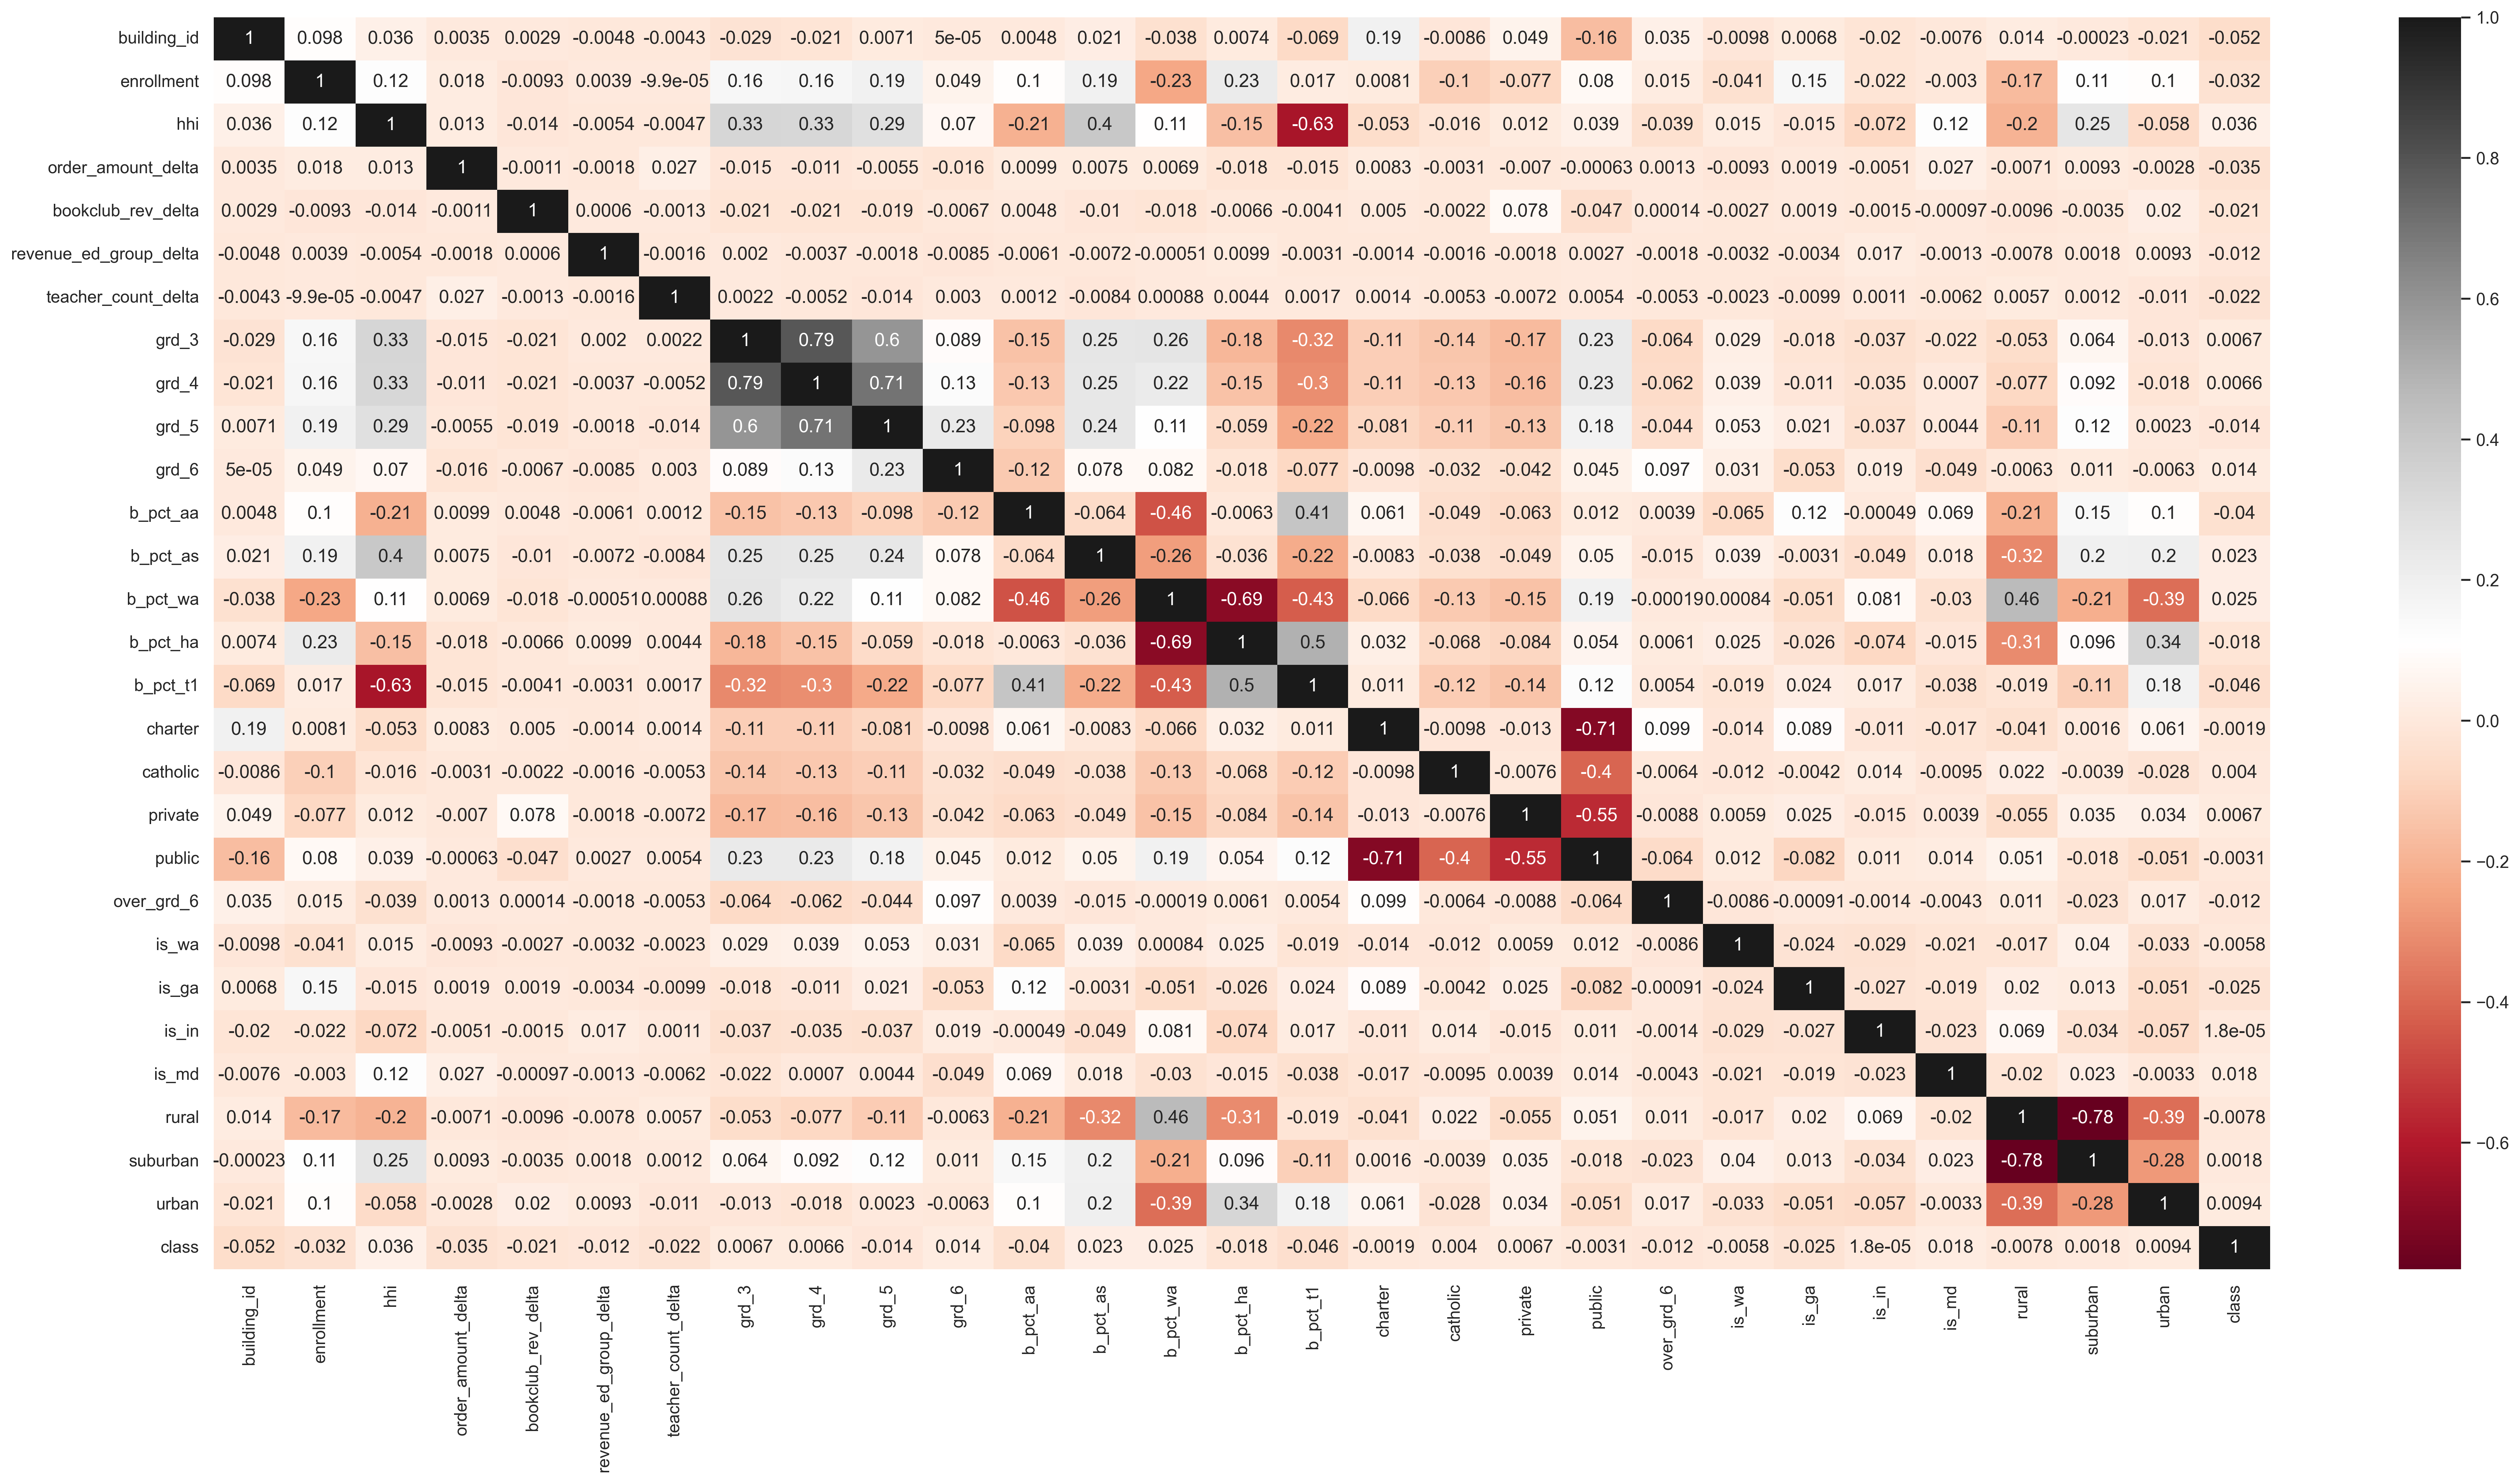

In [631]:
plt.figure(figsize=(30,15))
sns.heatmap(combined.corr(), cmap="RdGy", annot=True)
plt.show()

## Addressing Multicollinarity
- Obvious correlations
    - HHI and T1 eligibility
    - Racial demographics
    - High grade scores

## Backward Feature Selection

In [632]:
features = combined.copy()
features = features.drop(columns='building_id')
classes = features.pop('class')

In [663]:
backward = SequentialFeatureSelector(LogisticRegression(max_iter=100e10),
                                     k_features=(2, 8),
                                     forward=False, floating=True,
                                     verbose=2, scoring='f1', cv=5)

In [664]:
backward.fit(features, classes)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   11.0s finished

[2022-11-13 23:05:27] Features: 26/2 -- score: 0.8799744032001277[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:   10.4s finished

[2022-11-13 23:05:37] Features: 25/2 -- score: 0.8799744032001277[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jo

SequentialFeatureSelector(estimator=LogisticRegression(max_iter=1000000000000.0),
                          floating=True, forward=False, k_features=(2, 8),
                          scoring='f1', verbose=2)

In [665]:
final_features = list(backward.k_feature_names_)
final_features.append('class')
final_features

['enrollment',
 'hhi',
 'bookclub_rev_delta',
 'revenue_ed_group_delta',
 'teacher_count_delta',
 'grd_3',
 'grd_4',
 'b_pct_aa',
 'class']

In [666]:
# Model F1 score
backward.k_score_

0.8799744032001277

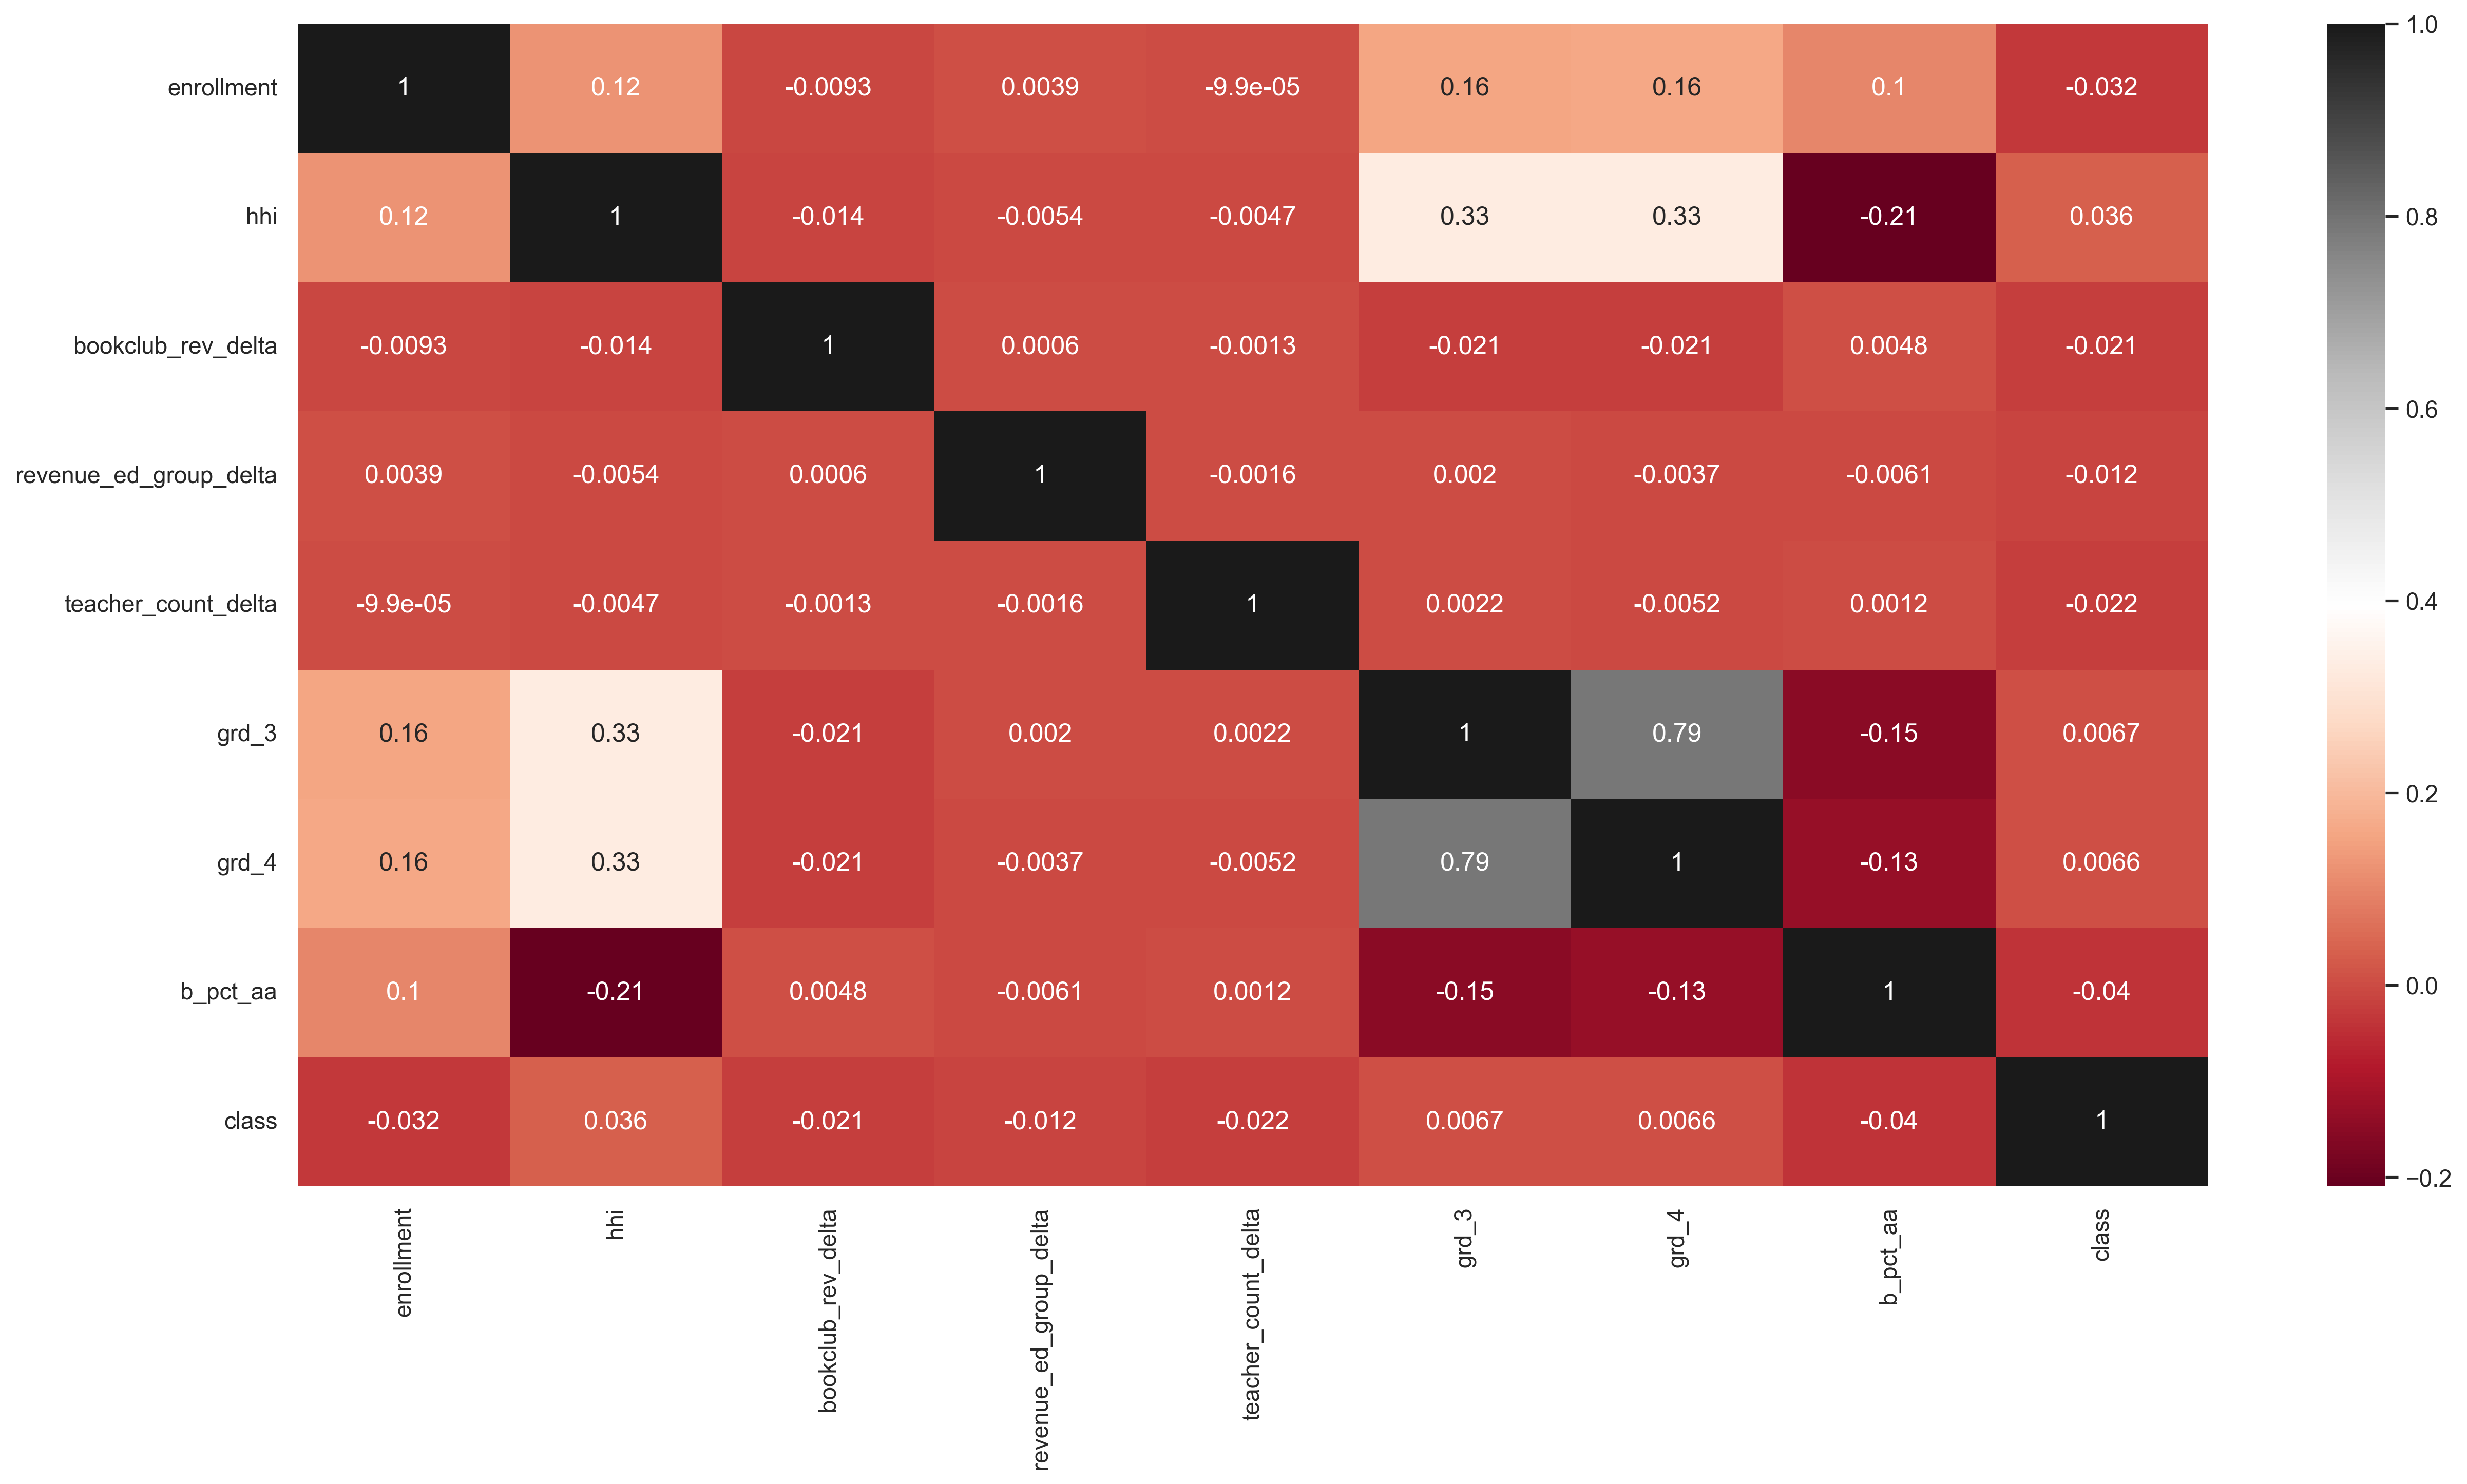

In [667]:
plt.figure(figsize=(20,10))
sns.heatmap(combined[final_features].corr(), cmap="RdGy", annot=True)
plt.show()

### No real multicollinearity here!

In [668]:
combined[final_features].to_csv('Data/selected_features.csv')